In [1]:
import io
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import base64

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium
sys.modules["gym"] = gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gym import spaces
from gym.envs.box2d.lunar_lander import *
from gym.wrappers.monitoring.video_recorder import VideoRecorder


from collections import namedtuple, deque
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment CartPole-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment CartPole-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment MountainCar-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment MountainCarContinuous-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\envs\regist

In [2]:
# @title Вспомогательная функция вывода в виртуальный дисплей
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()



FileNotFoundError: [WinError 2] Не удается найти указанный файл

In [3]:
"""
Функция позволяет записывать видео из gym и отображать его.
Чтобы включить видео, просто выполните "env = wrap_env(env)""
"""
def render_mp4(videopath: str) -> str:
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [4]:
env = gym.make(
    "LunarLander-v2",
    continuous = False,
    gravity = -10.0,
    enable_wind = False,
    wind_power = 15.0,
    turbulence_power = 1.5,
)

In [5]:
observation, info = env.reset()

for _ in range(1000):
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()
print(reward)

0.7782928569080922


In [6]:
nn_layers = [64, 64, 64]  # Это конфигурация вашей нейронной сети. В настоящее время у нас есть два слоя, каждый из которых состоит из 64 нейронов.
                      # Если вам нужны три слоя по 64 нейрона в каждом, установите значение [64,64,64] и так далее.

learning_rate = 0.0001   # Это размер шага, с которым выполняется градиентный спуск.
                       # Совет: Используйте меньшие размеры шага для более крупных сетей.

In [7]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env_name = 'LunarLander-v2'
env = gym.make(env_name)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  # for simplicity, we are not doing batch update.
            buffer_size=1,  # size of experience of replay buffer. Set to 1 as batch update is not done
            learning_starts=1,  # learning starts immediately!
            gamma=0.99,  # discount facto. range is between 0 and 1.
            tau = 1,  # the soft update coefficient for updating the target network
            target_update_interval=1,  # update the target network immediately.
            train_freq=(1,"step"),  # train the network at every step.
            max_grad_norm = 10,  # the maximum value for the gradient clipping
            exploration_initial_eps = 1,  # initial value of random action probability
            exploration_fraction = 0.5,  # fraction of entire training period over which the exploration rate is reduced
            gradient_steps = 1,  # number of gradient steps
            seed = 1,  # seed for the pseudo random generators
            verbose=0)  # Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.


In [8]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
print('Пространство наблюдений (состояний): ', env.observation_space.shape)
print('Пространство действий:: ', env.action_space.n)

Пространство наблюдений (состояний):  (8,)
Пространство действий::  4


In [11]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_pretraining.mp4")
observation = env.reset()[0]
print(observation)

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining.mp4")
HTML(html)

[-1.7509461e-04  1.4217051e+00 -1.7750543e-02  4.7932699e-01
  2.0966219e-04  4.0207128e-03  0.0000000e+00  0.0000000e+00]
Moviepy - Building video video/LunarLander-v2_pretraining.mp4.
Moviepy - Writing video video/LunarLander-v2_pretraining.mp4



Moviepy - Done !
Moviepy - video ready video/LunarLander-v2_pretraining.mp4

Total reward: -94.55235632133136


In [12]:
model.learn(total_timesteps=150000, log_interval=10, callback=callback)
# Результаты обучения будут распечатываться каждые 10 серий. При желании измените это значение на 1
# просматривайте результаты каждого тренировочного эпизода.

Eval num_timesteps=10000, episode_reward=-1105.24 +/- 401.10
Episode length: 315.40 +/- 74.09
New best mean reward!
Eval num_timesteps=20000, episode_reward=-857.20 +/- 84.55
Episode length: 467.00 +/- 23.44
New best mean reward!
Eval num_timesteps=30000, episode_reward=-236.01 +/- 84.94
Episode length: 231.00 +/- 69.73
New best mean reward!
Eval num_timesteps=40000, episode_reward=-105.84 +/- 51.39
Episode length: 228.80 +/- 76.76
New best mean reward!
Eval num_timesteps=50000, episode_reward=-465.60 +/- 308.80
Episode length: 326.80 +/- 222.61
Eval num_timesteps=60000, episode_reward=-17.92 +/- 95.31
Episode length: 192.80 +/- 79.20
New best mean reward!
Eval num_timesteps=70000, episode_reward=-343.23 +/- 162.66
Episode length: 391.40 +/- 140.43
Eval num_timesteps=80000, episode_reward=-172.18 +/- 42.29
Episode length: 334.40 +/- 168.21
Eval num_timesteps=90000, episode_reward=-80.67 +/- 224.69
Episode length: 616.20 +/- 144.50
Eval num_timesteps=100000, episode_reward=-517.35 +/- 2

In [15]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_learned.mp4")
observation = env.reset()[0]

total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action, states = model.predict(observation, deterministic=True)
  # print(states)
  # print('action  = ' , action)
  observation, reward, done, info, _ = env.step(action)
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned.mp4")
HTML(html)

Moviepy - Building video video/LunarLander-v2_learned.mp4.
Moviepy - Writing video video/LunarLander-v2_learned.mp4



Moviepy - Done !
Moviepy - video ready video/LunarLander-v2_learned.mp4

Total reward: -675.6878762973548


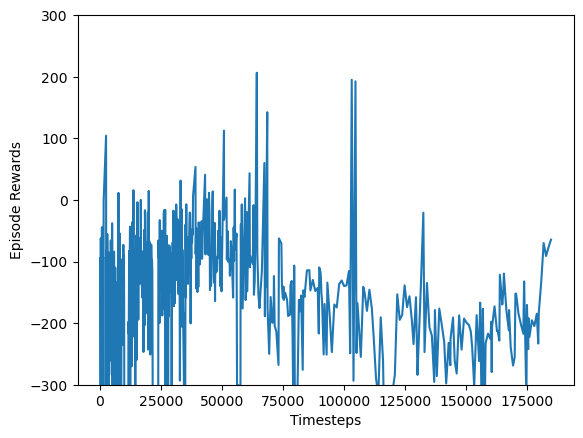

In [17]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

In [18]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
from torch.nn import functional as F
from stable_baselines3 import DQN

In [20]:
from tqdm import tqdm
from itertools import count
import random

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class DDQN(nn.Module):

    def __init__(self, n_observations, n_actions, hidden_size = 128):
        super(DDQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
        
# class Policy(nn.Module):

#     def __init__(self, lr, n_observations, n_actions, batch_size, hidden_size, target_net):
#         super(Policy, self).__init__()
#         self.lr = lr
#         self.n_observations = n_observations
#         self.n_actions = n_actions
#         self.batch_size = batch_size
#         self.hidden_size = hidden_size
#         self.optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)
#         self.criterion = nn.SmoothL1Loss()
#         self.layer1 = nn.Linear(n_observations, hidden_size)
#         self.layer2 = nn.Linear(hidden_size, hidden_size)
#         self.layer3 = nn.Linear(hidden_size, n_actions)
        
#     def forward(self, x):
#         x = F.relu(self.layer1(x))
#         x = F.relu(self.layer2(x))
#         return self.layer3(x)
        
    # def learn(self, memory):
    #     if len(memory) < self.batch_size:
    #         return
    #     transitions = memory.sample(self.batch_size)
    #     batch = Transition(*zip(*transitions))
    #     non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
    #                                         batch.next_state)), device=device, dtype=torch.bool)
    #     non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    #     state_batch = torch.cat(batch.state)
    #     action_batch = torch.cat(batch.action)
    #     reward_batch = torch.cat(batch.reward)
    #     state_action_values = self.forward(state_batch).gather(1, action_batch)
    #     next_state_values = torch.zeros(self.batch_size, device=device)
    #     with torch.no_grad():
    #         next_state_values[non_final_mask] = target_net.forward(non_final_next_states).max(1)[0]
    #     expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
    #     loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #     self.optimizer.zero_grad()
    #     loss.backward()
    #     torch.nn.utils.clip_grad_value_(self.parameters(), 100)
    #     self.optimizer.step()

batch_size = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000
hidden_size = 128
num_episodes = 1000

n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DDQN(n_observations=n_observations, n_actions=n_actions).to(device)
target_net = DDQN(n_observations=n_observations, n_actions=n_actions).to(device)
#policy_net = Policy(lr=LR, n_observations=n_observations, n_actions=n_actions, 
#                    batch_size=batch_size, hidden_size = hidden_size, target_net=target_net).to(device)

target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()
memory = ReplayMemory(FULL_MEMORY_LENGTH)
steps_done = 0
episode_durations = []

i = 0

total_reward = []
for episode in tqdm(range(num_episodes)):
    episode_reward = 0
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    
    while not done:
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END)/math.exp(i/EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
                action = policy_net.forward(state).max(1)[1].view(1, 1)
        else:
            action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        i +=1
        observation, reward, terminated, truncated, _ = env.step(action.item())
        episode_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        #policy_net.learn(memory)
        if len(memory) < batch_size:
            pass
        else:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)
            state_action_values = policy_net(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(batch_size, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
            expected_state_action_values = (next_state_values * GAMMA) + reward_batch
            
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
            optimizer.step()
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)
            if done:
                episode_durations.append(i)
                total_reward.append(episode_reward)
            

  2%|▏         | 17/1000 [00:08<21:24,  1.31s/it]C:\ProgramData\anaconda3\Lib\site-packages\gymnasium\wrappers\monitoring\video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
100%|██████████| 1000/1000 [14:37<00:00,  1.14it/s]


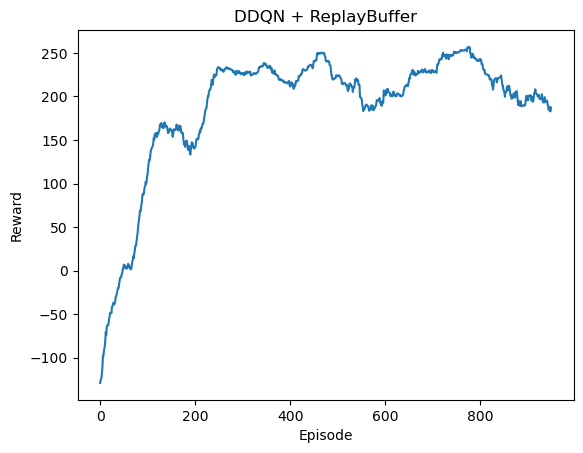

In [21]:
window_size = 50
moving_avg = np.convolve(total_reward, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DDQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [38]:
env = gym.make(env_name, render_mode="rgb_array")
vid = VideoRecorder(env, path=f"video/{env_name}_DQN.mp4")
observation = env.reset()[0]
observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
total_reward = 0
done = False
while not done:
  frame = env.render()
  vid.capture_frame()
  action = target_net.forward(torch.tensor(observation).to(device))
  action = action.argmax()
  observation, reward, done, info, _ = env.step(action.item()) #.detach().cpu().numpy()
  total_reward += reward
vid.close()
env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_DQN.mp4")
HTML(html)

C:\Users\LeoFH\AppData\Local\Temp\ipykernel_6312\1105339735.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = target_net.forward(torch.tensor(observation).to(device))


Moviepy - Building video video/LunarLander-v2_DQN.mp4.
Moviepy - Writing video video/LunarLander-v2_DQN.mp4



Moviepy - Done !
Moviepy - video ready video/LunarLander-v2_DQN.mp4

Total reward: 286.77713003805644


#### Далее можно не смотреть. Я неделю эксперементировал с разными реализациями, но ничего толком не вышло. Кое что решил на будущее оставить. Очень чуствительтная конструкция эта DQN.

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env_name = 'LunarLander-v2'
env = gym.make(env_name)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
FULL_MEMORY_LENGTH = 10000

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  # For evaluating the performance of the agent periodically and logging the results.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
Policy_net = DQN("MlpPolicy", env, policy_kwargs = policy_kwargs, learning_rate=LR, batch_size=BATCH_SIZE, buffer_size=FULL_MEMORY_LENGTH,
                 learning_starts=1, gamma=GAMMA,  tau = TAU,  target_update_interval=1,  train_freq=(1,"step"),  max_grad_norm = 10,  
                 exploration_initial_eps = 1, exploration_fraction = 0.2, gradient_steps = 1, verbose=1)

Target_net = DQN("MlpPolicy", env, policy_kwargs = policy_kwargs, learning_rate=LR, batch_size=BATCH_SIZE, buffer_size=FULL_MEMORY_LENGTH,
                 learning_starts=1, gamma=GAMMA,  tau = TAU,  target_update_interval=1,  train_freq=(1,"step"),  max_grad_norm = 10,  
                 exploration_initial_eps = 1, exploration_fraction = 0.2, gradient_steps = 1, verbose=1)

n_actions = env.action_space.n
# Получить число степеней свободы состояний
state, info = env.reset()
n_observations = len(state)

policy_net = model(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)

# Подгрузить в целевую сеть коэффициенты из сети политики
target_net.load_state_dict(policy_net.state_dict())

# Задать оптимайзер
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

# Инициализировать Replay Memory buffer
memory = ReplayMemory(FULL_MEMORY_LENGTH)


steps_done = 0

#     массив длительности эпизода - пойдет в отчет о том, сколько продержался агент
episode_durations = []

In [116]:
class ReplayBuffer():
    def __init__(self, buff_size, input_shape):
        self.buff_size = buff_size
        self.buff_current_ind = 0
        self.state_buff = deque([], maxlen=buff_size)
        #np.zeros((self.buff_size, *input_shape), dtype=np.float32)
        self.action_buff = deque([], maxlen=buff_size)
        #np.zeros(self.buff_size, dtype=np.int64)
        self.new_state_buff = deque([], maxlen=buff_size)
        #np.zeros((self.buff_size, *input_shape), dtype=np.float32)
        self.reward_buff = deque([], maxlen=buff_size)
        #np.zeros(self.buff_size, dtype=np.float32)
        self.terminate_buff = deque([], maxlen=buff_size)
        #np.zeros(self.buff_size, dtype=np.uint8)

    def push(self, state, action, reward, next_state, done):
        #print(self.state_buff.shape, state)
        self.state_buff.append(state)
        self.action_buff.append(action)
        self.new_state_buff.append(next_state)
        self.reward_buff.append(reward)
        self.terminate_buff.append(done)
        self.buff_current_ind += 1


    def sample(self, batch_size):
        if self.buff_current_ind < batch_size:
            batch = self.buff_current_ind
        else:
            batch = batch_size
        
        #print(batch)
        #print(random.sample(self.state_buff, batch))
        states = np.array(random.sample(self.state_buff, batch), dtype=np.float32)
        actions = np.array(random.sample(self.action_buff, batch), dtype=np.int64)
        rewards = np.array(random.sample(self.reward_buff, batch), dtype=np.float32)
        next_states = np.array(random.sample(self.new_state_buff, batch), dtype=np.float32)
        terminal = np.array(random.sample(self.terminate_buff, batch), dtype=np.uint8)
        return states, actions, rewards, next_states, terminal

In [151]:

        
class ReplayBuffer():
    def __init__(self, buff_size, input_shape):
        self.buff_size = buff_size
        self.buff_current_ind = 0
        self.state_buff = np.zeros((self.buff_size, input_shape), dtype=np.float32)
        self.action_buff = np.zeros(self.buff_size, dtype=np.int64)
        self.new_state_buff = np.zeros((self.buff_size, input_shape), dtype=np.float32)
        self.reward_buff = np.zeros(self.buff_size, dtype=np.float32)
        self.terminate_buff = np.zeros(self.buff_size, dtype=np.uint8)

    def push(self, state, action, reward, next_state, done):
        #print(self.state_buff.shape, state)
        ind = self.buff_current_ind % self.buff_size
        self.state_buff[ind] = state[0]
        self.action_buff[ind] = action
        self.new_state_buff[ind] = next_state
        self.reward_buff[ind] = reward
        self.terminate_buff[ind] = done
        self.buff_current_ind += 1
        

    def sample(self, batch_size):
        if self.buff_current_ind < self.buff_size:
            batch = np.random.choice(self.buff_current_ind, batch_size, replace = False)
        else:
            batch = np.random.choice(self.buff_size, batch_size, replace = False)
            
        states = self.state_buff[batch]
        actions = self.action_buff[batch]
        rewards = self.reward_buff[batch]
        next_states = self.new_state_buff[batch]
        terminal = self.terminate_buff[batch]
        return states, actions, rewards, next_states, terminal

    



In [155]:
class DoubleDQN(nn.Module):

    def __init__(self, lr, hidden_shape, n_actions, inp_size, device):
        
        super(DoubleDQN, self).__init__()
        self.layer1 = nn.Linear(inp_size, hidden_shape)
        #self.layer2 = nn.Linear(hidden_shape, hidden_shape)
        self.Val = nn.Linear(hidden_shape, n_actions)
        self.Act = nn.Linear(hidden_shape, 1)
        
        #self.loss = nn.SmoothL1Loss()
        self.loss = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.device = device
        self.to(self.device)

    def forward(self, state):
        x1 = F.relu(self.layer1(state))
        #x2 = F.relu(self.layer2(x1))
        return self.Val(x1), self.Act(x1)
        

In [170]:
#eps_threshold = EPS_END + (EPS_START - EPS_END) /math.exp(steps_done / EPS_DECAY)
class DoubleDQNAgent(nn.Module):
    def __init__(self, lr, gamma, eps, inp_size, n_actions, buff_size, batch_size, device, hidden_shape = 256,
                eps_min = 0.01, eps_dec = 1e-6, replace = 1000):
        super(DoubleDQNAgent, self).__init__()
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self.inp_size = inp_size 
        self.buff_size = buff_size 
        self.batch_size = batch_size 
        self.eps_min = eps_min 
        self.eps_dec = eps_dec 
        self.replace = replace
        self.action_space = [i for i in range(self.n_actions)]
        self.device = device
        self.learn_step_counter = 0
        self.hidden_shape = hidden_shape
        self.mem = ReplayBuffer(buff_size, inp_size)
        self.policy = DoubleDQN(lr = self.lr, hidden_shape = self.hidden_shape,  n_actions = self.n_actions, 
                                inp_size = self.inp_size, device=self.device)
        self.target = DoubleDQN(lr = self.lr, hidden_shape = self.hidden_shape,  n_actions = self.n_actions, 
                                inp_size = self.inp_size, device=self.device)

    def greedy_action(self, obs):
        if np.random.random()>self.eps:
            # if len(obs) != self.inp_size:
            #     obs = obs[0]
            #     #print('passed')
            #     #print(len(obs), obs)
            state = torch.tensor([obs], dtype=torch.float).to(self.policy.device)
            _, next_ = self.policy.forward(state)
            action = torch.argmax(next_).item()
        else:
            action = np.random.choice(self.action_space)
        return action

    def save_trans(self, state, action, reward, next_state, done):
        self.mem.push(state, action, reward, next_state, done)

    def replace_tn(self):
        if self.learn_step_counter % self.replace == 0:
            self.target.load_state_dict(self.policy.state_dict())

    def eps_decay(self):
        if self.eps > self.eps_min:
            self.eps -= self.eps_dec
        else: 
            self.eps_min
    def learn(self):
        if self.mem.buff_current_ind < self.batch_size:
            return
        
        self.policy.optimizer.zero_grad()
        self.replace_tn()
        #print(self.eps)
        state, action, reward, next_state, done = self.mem.sample(self.batch_size)
        state_th = torch.tensor(state).to(self.policy.device)
        action_th = torch.tensor(action).to(self.policy.device) 
        reward_th = torch.tensor(reward).to(self.policy.device)
        next_state_th = torch.tensor(next_state).to(self.policy.device)
        done_th = torch.tensor(done).to(self.policy.device)
        idx = np.arange(self.batch_size, dtype = np.int64)
        values, actions = self.policy.forward(state_th)
        new_values, new_actions = self.target.forward(next_state_th)
        next_new_values, next_new_actions = self.policy.forward(next_state_th)
        Q = torch.add(values, (actions - actions.mean(dim=1, keepdim=True)))[idx, action_th]
        Q_next = torch.add(new_values, (new_actions - new_actions.mean(dim=1, keepdim=True)))
        Q_next_new = torch.add(next_new_values, (next_new_actions - next_new_actions.mean(dim=1, keepdim=True)))
        max_actions = torch.argmax(Q_next_new, dim=1)
        #print(done_th)
        Q_next[torch.from_numpy(done)] = 0.
        #Q_next[done_th] = 0.
        Q_target = reward_th + self.gamma*Q_next[idx, max_actions]
        loss = self.policy.loss(Q_target, Q).to(device)
        loss.backward()
        self.policy.optimizer.step()
        self.learn_step_counter +=1
        self.eps_decay()
        
        
        

env_name = 'LunarLander-v2'
env = gym.make(env_name)

In [171]:
from tqdm import tqdm
num_epizodes =  1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inp_size = 8
# policy_net = DoubleDQN(lr = 1e-4, hidden_shape = 256,  n_actions = 4, inp_size = inp_size, device=device)
# target_net = DoubleDQN(lr = 1e-4, hidden_shape = 256,  n_actions = 4, inp_size = inp_size, device=device)
agent = DoubleDQNAgent(lr = 1e-5, gamma = 0.99, eps = 0.99, inp_size = inp_size, n_actions = 4, hidden_shape = 512,  
                       buff_size = 100000, device=device, batch_size = 128,  eps_min = 0.01, eps_dec = 1e-4, replace = 100)
scores = []
eps_hist = []

for i in tqdm(range(num_epizodes)):
    done = False
    obs = env.reset()[0]
    score = 0
    while not done:
        #print(obs[0])
        action = agent.greedy_action(obs)
        #print(action)
        #print(env.step(action))
        next_obs, reward, term, trun, info = env.step(action)
        #print(next_obs)
        score += reward
        #print(obs)
        agent.save_trans(obs, action, reward, next_obs, int(done))
        agent.learn()
        obs = next_obs
        done = term or trun
        #print(done)
    scores.append(score)
    av_score = np.mean(scores[-100:])
    # if i%100 == 99:
    print('epizode ', i , 'score %1f' % score, 'average score %1f' % av_score, 'epsilon %2f' % agent.eps) 
    eps_hist.append(agent.eps)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\LeoFH\AppData\Local\Temp\ipykernel_22920\494344546.py:73: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  Q_next[torch.from_numpy(done)] = 0.
  0%|          | 2/1000 [00:00<01:39,  9.98it/s]

epizode  0 score -86.028310 average score -86.028310 epsilon 0.990000
epizode  1 score -507.986003 average score -297.007156 epsilon 0.984000


  0%|          | 4/1000 [00:00<02:48,  5.91it/s]

epizode  2 score -153.300897 average score -249.105070 epsilon 0.974300
epizode  3 score -90.628233 average score -209.485861 epsilon 0.963100


  1%|          | 6/1000 [00:00<02:50,  5.84it/s]

epizode  4 score -327.166169 average score -233.021922 epsilon 0.955700
epizode  5 score -354.052634 average score -253.193708 epsilon 0.945500


  1%|          | 8/1000 [00:01<02:59,  5.52it/s]

epizode  6 score -41.857800 average score -223.002864 epsilon 0.934500
epizode  7 score -140.241391 average score -212.657680 epsilon 0.925700


  1%|          | 10/1000 [00:01<03:16,  5.04it/s]

epizode  8 score -422.929294 average score -236.021192 epsilon 0.913500
epizode  9 score -314.632641 average score -243.882337 epsilon 0.903200


  1%|          | 12/1000 [00:02<02:39,  6.20it/s]

epizode  10 score -77.203592 average score -228.729724 epsilon 0.897000
epizode  11 score -65.657113 average score -215.140340 epsilon 0.890500


  1%|▏         | 14/1000 [00:02<03:09,  5.21it/s]

epizode  12 score -65.342806 average score -203.617453 epsilon 0.879100
epizode  13 score -237.079774 average score -206.007618 epsilon 0.867700


  2%|▏         | 16/1000 [00:02<02:34,  6.36it/s]

epizode  14 score -70.216667 average score -196.954888 epsilon 0.861100
epizode  15 score -85.155199 average score -189.967408 epsilon 0.855100


  2%|▏         | 18/1000 [00:02<02:22,  6.88it/s]

epizode  16 score -96.236328 average score -184.453815 epsilon 0.849000
epizode  17 score -96.635311 average score -179.575009 epsilon 0.841800


  2%|▏         | 20/1000 [00:03<02:42,  6.02it/s]

epizode  18 score -160.342524 average score -178.562773 epsilon 0.832100
epizode  19 score -138.454636 average score -176.557366 epsilon 0.823100


  2%|▏         | 22/1000 [00:03<02:50,  5.73it/s]

epizode  20 score -238.965756 average score -179.529194 epsilon 0.812700
epizode  21 score -116.699752 average score -176.673310 epsilon 0.804100


  2%|▏         | 24/1000 [00:04<02:35,  6.26it/s]

epizode  22 score -109.788722 average score -173.765285 epsilon 0.796400
epizode  23 score -100.089676 average score -170.695468 epsilon 0.789400


  3%|▎         | 26/1000 [00:04<02:43,  5.97it/s]

epizode  24 score -197.681534 average score -171.774911 epsilon 0.779500
epizode  25 score -188.798191 average score -172.429652 epsilon 0.771600


  3%|▎         | 28/1000 [00:04<02:28,  6.56it/s]

epizode  26 score -131.553724 average score -170.915729 epsilon 0.764800
epizode  27 score -100.929050 average score -168.416205 epsilon 0.757700


  3%|▎         | 29/1000 [00:04<02:20,  6.90it/s]

epizode  28 score -70.682568 average score -165.046079 epsilon 0.751400


  3%|▎         | 31/1000 [00:05<02:37,  6.14it/s]

epizode  29 score -138.861321 average score -164.173254 epsilon 0.741000
epizode  30 score -134.398143 average score -163.212766 epsilon 0.732800


  3%|▎         | 33/1000 [00:05<02:40,  6.01it/s]

epizode  31 score -281.967106 average score -166.923840 epsilon 0.725600
epizode  32 score -329.269390 average score -171.843402 epsilon 0.716200


  4%|▎         | 35/1000 [00:05<02:23,  6.75it/s]

epizode  33 score -85.372204 average score -169.300131 epsilon 0.709900
epizode  34 score -116.287458 average score -167.785483 epsilon 0.703100


  4%|▎         | 37/1000 [00:06<02:26,  6.57it/s]

epizode  35 score -309.689051 average score -171.727249 epsilon 0.693600
epizode  36 score -127.491026 average score -170.531675 epsilon 0.686800


  4%|▍         | 39/1000 [00:06<02:23,  6.68it/s]

epizode  37 score -285.579014 average score -173.559237 epsilon 0.677700
epizode  38 score -63.187957 average score -170.729204 epsilon 0.671700


  4%|▍         | 40/1000 [00:06<02:12,  7.23it/s]

epizode  39 score -84.001439 average score -168.561010 epsilon 0.666100


  4%|▍         | 42/1000 [00:06<02:46,  5.75it/s]

epizode  40 score -154.886285 average score -168.227480 epsilon 0.654200
epizode  41 score -147.097614 average score -167.724388 epsilon 0.645000


  4%|▍         | 44/1000 [00:07<02:40,  5.97it/s]

epizode  42 score -130.284950 average score -166.853704 epsilon 0.636800
epizode  43 score -99.434536 average score -165.321450 epsilon 0.629800


  5%|▍         | 46/1000 [00:07<02:33,  6.20it/s]

epizode  44 score -294.523069 average score -168.192597 epsilon 0.621000
epizode  45 score 52.290215 average score -163.399492 epsilon 0.614600


  5%|▍         | 48/1000 [00:07<02:20,  6.76it/s]

epizode  46 score -201.969109 average score -164.220122 epsilon 0.608200
epizode  47 score -104.699267 average score -162.980105 epsilon 0.601700


  5%|▌         | 50/1000 [00:08<02:13,  7.11it/s]

epizode  48 score -109.286683 average score -161.884320 epsilon 0.595200
epizode  49 score -84.422370 average score -160.335081 epsilon 0.588600


  5%|▌         | 52/1000 [00:08<02:33,  6.19it/s]

epizode  50 score -125.607477 average score -159.654148 epsilon 0.577300
epizode  51 score -79.842730 average score -158.119313 epsilon 0.570200


  5%|▌         | 54/1000 [00:08<02:33,  6.16it/s]

epizode  52 score -212.898931 average score -159.152891 epsilon 0.560000
epizode  53 score -74.961859 average score -157.593798 epsilon 0.553300


  6%|▌         | 55/1000 [00:08<02:33,  6.17it/s]

epizode  54 score -155.989546 average score -157.564629 epsilon 0.545300


  6%|▌         | 56/1000 [00:09<02:53,  5.45it/s]

epizode  55 score -118.595798 average score -156.868757 epsilon 0.534300


  6%|▌         | 58/1000 [00:09<02:53,  5.44it/s]

epizode  56 score -147.908963 average score -156.711568 epsilon 0.523600
epizode  57 score -123.097282 average score -156.132011 epsilon 0.515900


  6%|▌         | 60/1000 [00:09<02:46,  5.66it/s]

epizode  58 score -119.974720 average score -155.519176 epsilon 0.506100
epizode  59 score -106.282533 average score -154.698565 epsilon 0.498500


  6%|▌         | 62/1000 [00:10<02:40,  5.86it/s]

epizode  60 score -102.562501 average score -153.843876 epsilon 0.491500
epizode  61 score -33.329950 average score -151.900103 epsilon 0.483100


  6%|▋         | 64/1000 [00:10<02:36,  5.98it/s]

epizode  62 score -137.159646 average score -151.666127 epsilon 0.474800
epizode  63 score -333.746573 average score -154.511134 epsilon 0.466900


  7%|▋         | 66/1000 [00:10<02:43,  5.70it/s]

epizode  64 score -165.271040 average score -154.676671 epsilon 0.458700
epizode  65 score -194.624436 average score -155.281940 epsilon 0.448500


  7%|▋         | 68/1000 [00:11<02:27,  6.31it/s]

epizode  66 score -94.396897 average score -154.373208 epsilon 0.439900
epizode  67 score -98.918932 average score -153.557704 epsilon 0.434200


  7%|▋         | 70/1000 [00:11<02:18,  6.73it/s]

epizode  68 score -140.242639 average score -153.364732 epsilon 0.427500
epizode  69 score -103.079336 average score -152.646369 epsilon 0.420400


  7%|▋         | 72/1000 [00:11<02:28,  6.27it/s]

epizode  70 score 20.711830 average score -150.204705 epsilon 0.414200
epizode  71 score -109.005864 average score -149.632499 epsilon 0.404000


  7%|▋         | 73/1000 [00:11<02:23,  6.46it/s]

epizode  72 score -116.176181 average score -149.174193 epsilon 0.396800


  8%|▊         | 75/1000 [00:12<02:24,  6.38it/s]

epizode  73 score -229.969909 average score -150.266027 epsilon 0.387100
epizode  74 score -144.709048 average score -150.191934 epsilon 0.381000


  8%|▊         | 77/1000 [00:12<02:24,  6.39it/s]

epizode  75 score -138.229125 average score -150.034528 epsilon 0.373700
epizode  76 score -138.684138 average score -149.887121 epsilon 0.365700


  8%|▊         | 79/1000 [00:12<02:16,  6.72it/s]

epizode  77 score -160.526317 average score -150.023521 epsilon 0.359100
epizode  78 score -182.438456 average score -150.433836 epsilon 0.351800


  8%|▊         | 81/1000 [00:13<02:01,  7.56it/s]

epizode  79 score -131.774106 average score -150.200590 epsilon 0.346100
epizode  80 score -75.917277 average score -149.283512 epsilon 0.340600


  8%|▊         | 83/1000 [00:13<02:10,  7.04it/s]

epizode  81 score -143.283430 average score -149.210340 epsilon 0.331100
epizode  82 score -114.231902 average score -148.788913 epsilon 0.325300


  8%|▊         | 84/1000 [00:13<02:16,  6.69it/s]

epizode  83 score -147.044724 average score -148.768149 epsilon 0.317100


  9%|▊         | 86/1000 [00:13<02:25,  6.26it/s]

epizode  84 score -388.886885 average score -151.593075 epsilon 0.305500
epizode  85 score -98.089986 average score -150.970946 epsilon 0.299600


  9%|▉         | 88/1000 [00:14<02:18,  6.56it/s]

epizode  86 score -57.037571 average score -149.891252 epsilon 0.290800
epizode  87 score -69.677705 average score -148.979735 epsilon 0.285200


  9%|▉         | 90/1000 [00:14<02:05,  7.28it/s]

epizode  88 score -157.548190 average score -149.076009 epsilon 0.279800
epizode  89 score -178.032918 average score -149.397753 epsilon 0.273500


  9%|▉         | 92/1000 [00:14<02:15,  6.69it/s]

epizode  90 score -185.386763 average score -149.793237 epsilon 0.266100
epizode  91 score -218.297059 average score -150.537843 epsilon 0.258100


  9%|▉         | 94/1000 [00:15<02:33,  5.92it/s]

epizode  92 score -83.481707 average score -149.816810 epsilon 0.249300
epizode  93 score -114.437220 average score -149.440431 epsilon 0.240300


 10%|▉         | 96/1000 [00:15<02:36,  5.76it/s]

epizode  94 score -132.304624 average score -149.260054 epsilon 0.232200
epizode  95 score -203.236259 average score -149.822306 epsilon 0.223500


 10%|▉         | 98/1000 [00:15<02:33,  5.87it/s]

epizode  96 score -167.703248 average score -150.006646 epsilon 0.215900
epizode  97 score -142.543745 average score -149.930494 epsilon 0.207500


 10%|█         | 100/1000 [00:16<02:26,  6.16it/s]

epizode  98 score -156.013131 average score -149.991935 epsilon 0.200400
epizode  99 score -175.877649 average score -150.250792 epsilon 0.193100


 10%|█         | 102/1000 [00:16<02:21,  6.37it/s]

epizode  100 score -228.601132 average score -151.676520 epsilon 0.184400
epizode  101 score -111.941693 average score -147.716077 epsilon 0.178300


 10%|█         | 104/1000 [00:16<02:21,  6.32it/s]

epizode  102 score -142.616656 average score -147.609234 epsilon 0.172000
epizode  103 score -184.707060 average score -148.550023 epsilon 0.163400


 11%|█         | 106/1000 [00:17<02:26,  6.11it/s]

epizode  104 score -170.792553 average score -146.986286 epsilon 0.154700
epizode  105 score -138.168033 average score -144.827440 epsilon 0.147600


 11%|█         | 108/1000 [00:17<02:20,  6.35it/s]

epizode  106 score -138.385307 average score -145.792716 epsilon 0.140800
epizode  107 score -141.027475 average score -145.800576 epsilon 0.133600


 11%|█         | 110/1000 [00:17<02:07,  6.98it/s]

epizode  108 score -104.079682 average score -142.612080 epsilon 0.128100
epizode  109 score -139.925760 average score -140.865011 epsilon 0.121700


 11%|█         | 112/1000 [00:18<02:03,  7.18it/s]

epizode  110 score -100.029533 average score -141.093271 epsilon 0.113700
epizode  111 score -104.231141 average score -141.479011 epsilon 0.108500


 11%|█▏        | 114/1000 [00:18<01:59,  7.44it/s]

epizode  112 score -164.322387 average score -142.468807 epsilon 0.101900
epizode  113 score -72.724521 average score -140.825254 epsilon 0.096600


 12%|█▏        | 115/1000 [00:18<02:08,  6.91it/s]

epizode  114 score -146.981176 average score -141.592899 epsilon 0.088600


 12%|█▏        | 117/1000 [00:18<02:18,  6.38it/s]

epizode  115 score -97.331841 average score -141.714666 epsilon 0.079200
epizode  116 score -150.602228 average score -142.258325 epsilon 0.072400


 12%|█▏        | 119/1000 [00:19<02:21,  6.24it/s]

epizode  117 score -93.359991 average score -142.225572 epsilon 0.066600
epizode  118 score -94.580949 average score -141.567956 epsilon 0.057800


 12%|█▏        | 121/1000 [00:19<02:18,  6.35it/s]

epizode  119 score -142.548861 average score -141.608898 epsilon 0.051600
epizode  120 score 22.781725 average score -138.991423 epsilon 0.043900


 12%|█▏        | 123/1000 [00:19<02:18,  6.32it/s]

epizode  121 score -123.356961 average score -139.057995 epsilon 0.037100
epizode  122 score -156.488238 average score -139.524991 epsilon 0.029400


 12%|█▎        | 125/1000 [00:20<02:22,  6.12it/s]

epizode  123 score -154.051230 average score -140.064606 epsilon 0.020300
epizode  124 score -19.318538 average score -138.280976 epsilon 0.013400


 13%|█▎        | 127/1000 [00:20<02:24,  6.06it/s]

epizode  125 score -138.869585 average score -137.781690 epsilon 0.009900
epizode  126 score -13.063313 average score -136.596786 epsilon 0.009900


 13%|█▎        | 129/1000 [00:20<02:04,  7.00it/s]

epizode  127 score -95.436441 average score -136.541860 epsilon 0.009900
epizode  128 score -139.474845 average score -137.229783 epsilon 0.009900


 13%|█▎        | 131/1000 [00:20<02:01,  7.13it/s]

epizode  129 score -154.672339 average score -137.387893 epsilon 0.009900
epizode  130 score -133.910515 average score -137.383017 epsilon 0.009900


 13%|█▎        | 133/1000 [00:21<02:04,  6.94it/s]

epizode  131 score -136.470698 average score -135.928053 epsilon 0.009900
epizode  132 score -59.781461 average score -133.233173 epsilon 0.009900


 14%|█▎        | 135/1000 [00:21<02:05,  6.89it/s]

epizode  133 score -182.058218 average score -134.200033 epsilon 0.009900
epizode  134 score -142.687802 average score -134.464037 epsilon 0.009900


 14%|█▎        | 137/1000 [00:21<02:05,  6.85it/s]

epizode  135 score -140.475791 average score -132.771904 epsilon 0.009900
epizode  136 score -141.680310 average score -132.913797 epsilon 0.009900


 14%|█▍        | 139/1000 [00:22<01:58,  7.26it/s]

epizode  137 score -119.905379 average score -131.257061 epsilon 0.009900
epizode  138 score -114.030674 average score -131.765488 epsilon 0.009900


 14%|█▍        | 140/1000 [00:22<02:01,  7.08it/s]

epizode  139 score -111.169293 average score -132.037166 epsilon 0.009900


 14%|█▍        | 142/1000 [00:22<02:46,  5.16it/s]

epizode  140 score -188.509118 average score -132.373395 epsilon 0.009900
epizode  141 score -162.790172 average score -132.530320 epsilon 0.009900


 14%|█▍        | 144/1000 [00:23<02:28,  5.78it/s]

epizode  142 score -138.027558 average score -132.607746 epsilon 0.009900
epizode  143 score -50.758546 average score -132.120987 epsilon 0.009900


 15%|█▍        | 146/1000 [00:23<02:25,  5.87it/s]

epizode  144 score -136.367415 average score -130.539430 epsilon 0.009900
epizode  145 score -105.332056 average score -132.115653 epsilon 0.009900


 15%|█▍        | 148/1000 [00:23<02:15,  6.28it/s]

epizode  146 score -118.091047 average score -131.276872 epsilon 0.009900
epizode  147 score -145.563539 average score -131.685515 epsilon 0.009900


 15%|█▌        | 150/1000 [00:23<02:06,  6.73it/s]

epizode  148 score -112.660936 average score -131.719257 epsilon 0.009900
epizode  149 score -132.681669 average score -132.201850 epsilon 0.009900


 15%|█▌        | 152/1000 [00:24<02:08,  6.62it/s]

epizode  150 score -149.452266 average score -132.440298 epsilon 0.009900
epizode  151 score -119.173053 average score -132.833601 epsilon 0.009900


 15%|█▌        | 154/1000 [00:24<02:17,  6.16it/s]

epizode  152 score -101.886791 average score -131.723480 epsilon 0.009900
epizode  153 score -211.633183 average score -133.090193 epsilon 0.009900


 16%|█▌        | 156/1000 [00:24<02:07,  6.62it/s]

epizode  154 score -17.926457 average score -131.709562 epsilon 0.009900
epizode  155 score -149.613975 average score -132.019744 epsilon 0.009900


 16%|█▌        | 158/1000 [00:25<02:07,  6.59it/s]

epizode  156 score -163.734372 average score -132.177998 epsilon 0.009900
epizode  157 score -123.348503 average score -132.180510 epsilon 0.009900


 16%|█▌        | 160/1000 [00:25<01:59,  7.03it/s]

epizode  158 score -161.116603 average score -132.591929 epsilon 0.009900
epizode  159 score -149.821127 average score -133.027315 epsilon 0.009900


 16%|█▌        | 162/1000 [00:25<02:02,  6.84it/s]

epizode  160 score -155.900247 average score -133.560693 epsilon 0.009900
epizode  161 score -153.770735 average score -134.765101 epsilon 0.009900


 16%|█▋        | 164/1000 [00:26<02:11,  6.34it/s]

epizode  162 score -130.613539 average score -134.699640 epsilon 0.009900
epizode  163 score -141.924029 average score -132.781414 epsilon 0.009900


 17%|█▋        | 166/1000 [00:26<02:00,  6.93it/s]

epizode  164 score -102.229204 average score -132.150996 epsilon 0.009900
epizode  165 score -159.962523 average score -131.804377 epsilon 0.009900


 17%|█▋        | 168/1000 [00:26<02:02,  6.81it/s]

epizode  166 score -143.631024 average score -132.296718 epsilon 0.009900
epizode  167 score -181.153901 average score -133.119068 epsilon 0.009900


 17%|█▋        | 170/1000 [00:26<01:56,  7.15it/s]

epizode  168 score -164.835749 average score -133.364999 epsilon 0.009900
epizode  169 score -131.471928 average score -133.648925 epsilon 0.009900


 17%|█▋        | 172/1000 [00:27<02:18,  5.97it/s]

epizode  170 score -165.829455 average score -135.514337 epsilon 0.009900
epizode  171 score -198.848572 average score -136.412764 epsilon 0.009900


 17%|█▋        | 174/1000 [00:27<02:11,  6.28it/s]

epizode  172 score -124.023708 average score -136.491240 epsilon 0.009900
epizode  173 score -145.473524 average score -135.646276 epsilon 0.009900


 18%|█▊        | 176/1000 [00:27<02:01,  6.76it/s]

epizode  174 score -160.036826 average score -135.799554 epsilon 0.009900
epizode  175 score -102.320163 average score -135.440464 epsilon 0.009900


 18%|█▊        | 178/1000 [00:28<01:53,  7.23it/s]

epizode  176 score -139.135517 average score -135.444978 epsilon 0.009900
epizode  177 score -92.546170 average score -134.765176 epsilon 0.009900


 18%|█▊        | 180/1000 [00:28<01:54,  7.15it/s]

epizode  178 score 20.962029 average score -132.731172 epsilon 0.009900
epizode  179 score -91.811653 average score -132.331547 epsilon 0.009900


 18%|█▊        | 182/1000 [00:28<01:49,  7.44it/s]

epizode  180 score -121.991071 average score -132.792285 epsilon 0.009900
epizode  181 score -93.936068 average score -132.298811 epsilon 0.009900


 18%|█▊        | 184/1000 [00:29<01:51,  7.35it/s]

epizode  182 score -134.210603 average score -132.498598 epsilon 0.009900
epizode  183 score -159.933153 average score -132.627483 epsilon 0.009900


 19%|█▊        | 186/1000 [00:29<01:58,  6.89it/s]

epizode  184 score -122.539747 average score -129.964011 epsilon 0.009900
epizode  185 score -125.262269 average score -130.235734 epsilon 0.009900


 19%|█▉        | 188/1000 [00:29<02:10,  6.23it/s]

epizode  186 score -154.798929 average score -131.213348 epsilon 0.009900
epizode  187 score -198.348215 average score -132.500053 epsilon 0.009900


 19%|█▉        | 190/1000 [00:29<02:09,  6.25it/s]

epizode  188 score -156.624178 average score -132.490813 epsilon 0.009900
epizode  189 score -159.271756 average score -132.303201 epsilon 0.009900


 19%|█▉        | 192/1000 [00:30<02:24,  5.59it/s]

epizode  190 score -170.454160 average score -132.153875 epsilon 0.009900
epizode  191 score -161.615381 average score -131.587058 epsilon 0.009900


 19%|█▉        | 194/1000 [00:30<02:10,  6.18it/s]

epizode  192 score -86.724450 average score -131.619486 epsilon 0.009900
epizode  193 score -113.622650 average score -131.611340 epsilon 0.009900


 20%|█▉        | 196/1000 [00:30<02:06,  6.38it/s]

epizode  194 score -118.897502 average score -131.477269 epsilon 0.009900
epizode  195 score -91.470310 average score -130.359609 epsilon 0.009900


 20%|█▉        | 198/1000 [00:31<01:51,  7.20it/s]

epizode  196 score -127.889664 average score -129.961473 epsilon 0.009900
epizode  197 score -117.338847 average score -129.709424 epsilon 0.009900


 20%|██        | 200/1000 [00:31<02:04,  6.41it/s]

epizode  198 score -147.078384 average score -129.620077 epsilon 0.009900
epizode  199 score -125.789426 average score -129.119195 epsilon 0.009900


 20%|██        | 202/1000 [00:31<01:57,  6.82it/s]

epizode  200 score -123.036352 average score -128.063547 epsilon 0.009900
epizode  201 score -122.082036 average score -128.164950 epsilon 0.009900


 20%|██        | 204/1000 [00:32<02:00,  6.58it/s]

epizode  202 score -86.532094 average score -127.604105 epsilon 0.009900
epizode  203 score -181.402867 average score -127.571063 epsilon 0.009900


 21%|██        | 206/1000 [00:32<02:00,  6.61it/s]

epizode  204 score -122.400505 average score -127.087142 epsilon 0.009900
epizode  205 score -182.260986 average score -127.528072 epsilon 0.009900


 21%|██        | 207/1000 [00:32<01:51,  7.11it/s]

epizode  206 score -105.814747 average score -127.202366 epsilon 0.009900


 21%|██        | 209/1000 [00:32<01:58,  6.70it/s]

epizode  207 score -153.272851 average score -127.324820 epsilon 0.009900
epizode  208 score -113.494210 average score -127.418965 epsilon 0.009900


 21%|██        | 211/1000 [00:33<01:58,  6.63it/s]

epizode  209 score -117.128052 average score -127.190988 epsilon 0.009900
epizode  210 score 24.088989 average score -125.949803 epsilon 0.009900


 21%|██▏       | 213/1000 [00:33<02:00,  6.53it/s]

epizode  211 score -137.676348 average score -126.284255 epsilon 0.009900
epizode  212 score -135.800060 average score -125.999032 epsilon 0.009900


 22%|██▏       | 215/1000 [00:33<01:58,  6.63it/s]

epizode  213 score -142.440219 average score -126.696189 epsilon 0.009900
epizode  214 score -121.545963 average score -126.441837 epsilon 0.009900


 22%|██▏       | 217/1000 [00:34<01:57,  6.68it/s]

epizode  215 score -155.001009 average score -127.018528 epsilon 0.009900
epizode  216 score -137.139068 average score -126.883897 epsilon 0.009900


 22%|██▏       | 219/1000 [00:34<01:52,  6.97it/s]

epizode  217 score -128.426092 average score -127.234558 epsilon 0.009900
epizode  218 score -132.378584 average score -127.612534 epsilon 0.009900


 22%|██▏       | 221/1000 [00:34<01:52,  6.94it/s]

epizode  219 score -180.061176 average score -127.987657 epsilon 0.009900
epizode  220 score -148.105518 average score -129.696530 epsilon 0.009900


 22%|██▏       | 223/1000 [00:34<01:50,  7.06it/s]

epizode  221 score -167.300392 average score -130.135964 epsilon 0.009900
epizode  222 score -125.000618 average score -129.821088 epsilon 0.009900


 22%|██▎       | 225/1000 [00:35<01:51,  6.94it/s]

epizode  223 score -199.126644 average score -130.271842 epsilon 0.009900
epizode  224 score -135.106863 average score -131.429725 epsilon 0.009900


 23%|██▎       | 227/1000 [00:35<01:51,  6.93it/s]

epizode  225 score -176.363085 average score -131.804660 epsilon 0.009900
epizode  226 score -109.326250 average score -132.767290 epsilon 0.009900


 23%|██▎       | 229/1000 [00:35<02:05,  6.12it/s]

epizode  227 score -94.682499 average score -132.759750 epsilon 0.009900
epizode  228 score -148.087671 average score -132.845878 epsilon 0.009900


 23%|██▎       | 231/1000 [00:36<02:05,  6.11it/s]

epizode  229 score -137.189234 average score -132.671047 epsilon 0.009900
epizode  230 score -125.265567 average score -132.584598 epsilon 0.009900


 23%|██▎       | 233/1000 [00:36<02:05,  6.10it/s]

epizode  231 score -134.716774 average score -132.567059 epsilon 0.009900
epizode  232 score -18.892417 average score -132.158168 epsilon 0.009900


 24%|██▎       | 235/1000 [00:36<02:07,  5.98it/s]

epizode  233 score -180.138849 average score -132.138974 epsilon 0.009900
epizode  234 score -64.467810 average score -131.356775 epsilon 0.009900


 24%|██▎       | 237/1000 [00:37<01:56,  6.55it/s]

epizode  235 score -143.893395 average score -131.390951 epsilon 0.009900
epizode  236 score -144.805953 average score -131.422207 epsilon 0.009900


 24%|██▍       | 239/1000 [00:37<02:09,  5.88it/s]

epizode  237 score -127.638730 average score -131.499541 epsilon 0.009900
epizode  238 score -136.028449 average score -131.719518 epsilon 0.009900


 24%|██▍       | 241/1000 [00:37<02:12,  5.71it/s]

epizode  239 score -87.961382 average score -131.487439 epsilon 0.009900
epizode  240 score -121.682799 average score -130.819176 epsilon 0.009900


 24%|██▍       | 243/1000 [00:38<02:02,  6.18it/s]

epizode  241 score -101.994864 average score -130.211223 epsilon 0.009900
epizode  242 score -136.321474 average score -130.194162 epsilon 0.009900


 24%|██▍       | 245/1000 [00:38<01:52,  6.69it/s]

epizode  243 score -128.789155 average score -130.974468 epsilon 0.009900
epizode  244 score -110.033724 average score -130.711131 epsilon 0.009900


 25%|██▍       | 247/1000 [00:38<01:41,  7.46it/s]

epizode  245 score -96.929400 average score -130.627105 epsilon 0.009900
epizode  246 score -90.794636 average score -130.354141 epsilon 0.009900


 25%|██▍       | 249/1000 [00:39<01:51,  6.76it/s]

epizode  247 score -133.915273 average score -130.237658 epsilon 0.009900
epizode  248 score -132.249151 average score -130.433540 epsilon 0.009900


 25%|██▌       | 251/1000 [00:39<01:49,  6.81it/s]

epizode  249 score -130.172143 average score -130.408445 epsilon 0.009900
epizode  250 score -123.401361 average score -130.147936 epsilon 0.009900


 25%|██▌       | 253/1000 [00:39<02:06,  5.91it/s]

epizode  251 score -159.361108 average score -130.549816 epsilon 0.009900
epizode  252 score -114.305073 average score -130.673999 epsilon 0.009900


 26%|██▌       | 255/1000 [00:40<01:58,  6.29it/s]

epizode  253 score -106.718324 average score -129.624851 epsilon 0.009900
epizode  254 score -133.739929 average score -130.782985 epsilon 0.009900


 26%|██▌       | 257/1000 [00:40<02:04,  5.98it/s]

epizode  255 score -96.576188 average score -130.252607 epsilon 0.009900
epizode  256 score -167.569837 average score -130.290962 epsilon 0.009900


 26%|██▌       | 259/1000 [00:40<01:48,  6.82it/s]

epizode  257 score 29.314164 average score -128.764335 epsilon 0.009900
epizode  258 score -79.946303 average score -127.952632 epsilon 0.009900


 26%|██▌       | 261/1000 [00:41<02:06,  5.83it/s]

epizode  259 score -187.765053 average score -128.332072 epsilon 0.009900
epizode  260 score -202.983660 average score -128.802906 epsilon 0.009900


 26%|██▋       | 263/1000 [00:41<02:09,  5.69it/s]

epizode  261 score -116.647730 average score -128.431676 epsilon 0.009900
epizode  262 score -162.714936 average score -128.752690 epsilon 0.009900


 26%|██▋       | 265/1000 [00:41<01:56,  6.30it/s]

epizode  263 score -64.694491 average score -127.980394 epsilon 0.009900
epizode  264 score -116.993214 average score -128.128034 epsilon 0.009900


 27%|██▋       | 267/1000 [00:42<02:00,  6.06it/s]

epizode  265 score -146.205235 average score -127.990462 epsilon 0.009900
epizode  266 score -93.968632 average score -127.493838 epsilon 0.009900


 27%|██▋       | 269/1000 [00:42<01:59,  6.10it/s]

epizode  267 score -170.035806 average score -127.382657 epsilon 0.009900
epizode  268 score -134.754875 average score -127.081848 epsilon 0.009900


 27%|██▋       | 271/1000 [00:42<01:57,  6.21it/s]

epizode  269 score -77.670378 average score -126.543832 epsilon 0.009900
epizode  270 score -140.249289 average score -126.288031 epsilon 0.009900


 27%|██▋       | 273/1000 [00:43<01:58,  6.12it/s]

epizode  271 score -135.874682 average score -125.658292 epsilon 0.009900
epizode  272 score -126.176644 average score -125.679821 epsilon 0.009900


 28%|██▊       | 275/1000 [00:43<02:10,  5.57it/s]

epizode  273 score -94.215966 average score -125.167246 epsilon 0.009900
epizode  274 score -14.294932 average score -123.709827 epsilon 0.009900


 28%|██▊       | 277/1000 [00:43<01:52,  6.44it/s]

epizode  275 score -131.244505 average score -123.999070 epsilon 0.009900
epizode  276 score -131.758805 average score -123.925303 epsilon 0.009900


 28%|██▊       | 279/1000 [00:43<01:43,  6.97it/s]

epizode  277 score -103.197803 average score -124.031819 epsilon 0.009900
epizode  278 score -129.472492 average score -125.536165 epsilon 0.009900


 28%|██▊       | 281/1000 [00:44<01:51,  6.45it/s]

epizode  279 score -165.768514 average score -126.275733 epsilon 0.009900
epizode  280 score -133.488172 average score -126.390704 epsilon 0.009900


 28%|██▊       | 283/1000 [00:44<01:46,  6.70it/s]

epizode  281 score -109.693836 average score -126.548282 epsilon 0.009900
epizode  282 score -114.730440 average score -126.353480 epsilon 0.009900


 28%|██▊       | 285/1000 [00:44<01:46,  6.72it/s]

epizode  283 score -113.745384 average score -125.891603 epsilon 0.009900
epizode  284 score -148.624697 average score -126.152452 epsilon 0.009900


 29%|██▊       | 287/1000 [00:45<01:45,  6.77it/s]

epizode  285 score -155.286880 average score -126.452698 epsilon 0.009900
epizode  286 score -119.540057 average score -126.100109 epsilon 0.009900


 29%|██▉       | 289/1000 [00:45<01:49,  6.52it/s]

epizode  287 score -161.620146 average score -125.732829 epsilon 0.009900
epizode  288 score -139.611651 average score -125.562703 epsilon 0.009900


 29%|██▉       | 291/1000 [00:45<01:55,  6.14it/s]

epizode  289 score -136.035537 average score -125.330341 epsilon 0.009900
epizode  290 score -114.428327 average score -124.770083 epsilon 0.009900


 29%|██▉       | 293/1000 [00:46<01:58,  5.96it/s]

epizode  291 score -160.360000 average score -124.757529 epsilon 0.009900
epizode  292 score -134.651653 average score -125.236801 epsilon 0.009900


 30%|██▉       | 295/1000 [00:46<02:01,  5.79it/s]

epizode  293 score -133.291312 average score -125.433488 epsilon 0.009900
epizode  294 score -207.335093 average score -126.317864 epsilon 0.009900


 30%|██▉       | 297/1000 [00:46<01:50,  6.35it/s]

epizode  295 score -176.705699 average score -127.170218 epsilon 0.009900
epizode  296 score -122.082248 average score -127.112143 epsilon 0.009900


 30%|██▉       | 299/1000 [00:47<01:43,  6.79it/s]

epizode  297 score -114.994268 average score -127.088698 epsilon 0.009900
epizode  298 score -101.131396 average score -126.629228 epsilon 0.009900


 30%|███       | 301/1000 [00:47<01:48,  6.42it/s]

epizode  299 score -86.183825 average score -126.233172 epsilon 0.009900
epizode  300 score -126.005148 average score -126.262860 epsilon 0.009900


 30%|███       | 303/1000 [00:47<01:46,  6.53it/s]

epizode  301 score -108.600923 average score -126.128049 epsilon 0.009900
epizode  302 score -149.417450 average score -126.756902 epsilon 0.009900


 30%|███       | 305/1000 [00:48<01:46,  6.53it/s]

epizode  303 score -125.948791 average score -126.202361 epsilon 0.009900
epizode  304 score -138.597878 average score -126.364335 epsilon 0.009900


 31%|███       | 307/1000 [00:48<01:42,  6.75it/s]

epizode  305 score -135.888536 average score -125.900611 epsilon 0.009900
epizode  306 score -119.946621 average score -126.041929 epsilon 0.009900


 31%|███       | 309/1000 [00:48<01:39,  6.91it/s]

epizode  307 score -140.568745 average score -125.914888 epsilon 0.009900
epizode  308 score -136.914276 average score -126.149089 epsilon 0.009900


 31%|███       | 311/1000 [00:48<01:47,  6.42it/s]

epizode  309 score -86.938864 average score -125.847197 epsilon 0.009900
epizode  310 score -118.503586 average score -127.273123 epsilon 0.009900


 31%|███       | 312/1000 [00:49<01:47,  6.41it/s]

epizode  311 score -137.299033 average score -127.269350 epsilon 0.009900


 31%|███▏      | 314/1000 [00:49<01:52,  6.12it/s]

epizode  312 score -44.074991 average score -126.352099 epsilon 0.009900
epizode  313 score -125.262334 average score -126.180320 epsilon 0.009900


 32%|███▏      | 316/1000 [00:49<01:47,  6.39it/s]

epizode  314 score -136.136645 average score -126.326227 epsilon 0.009900
epizode  315 score -134.642660 average score -126.122643 epsilon 0.009900


 32%|███▏      | 318/1000 [00:50<01:56,  5.84it/s]

epizode  316 score -158.420698 average score -126.335460 epsilon 0.009900
epizode  317 score -111.362482 average score -126.164824 epsilon 0.009900


 32%|███▏      | 320/1000 [00:50<02:00,  5.65it/s]

epizode  318 score -111.758622 average score -125.958624 epsilon 0.009900
epizode  319 score -107.010786 average score -125.228120 epsilon 0.009900


 32%|███▏      | 322/1000 [00:50<01:45,  6.41it/s]

epizode  320 score -138.659494 average score -125.133660 epsilon 0.009900
epizode  321 score -149.492607 average score -124.955582 epsilon 0.009900


 32%|███▏      | 324/1000 [00:51<01:36,  6.99it/s]

epizode  322 score -106.722972 average score -124.772806 epsilon 0.009900
epizode  323 score -107.286295 average score -123.854402 epsilon 0.009900


 33%|███▎      | 326/1000 [00:51<01:50,  6.11it/s]

epizode  324 score -142.412703 average score -123.927460 epsilon 0.009900
epizode  325 score -169.780332 average score -123.861633 epsilon 0.009900


 33%|███▎      | 328/1000 [00:51<01:49,  6.16it/s]

epizode  326 score -106.061027 average score -123.828981 epsilon 0.009900
epizode  327 score -135.479473 average score -124.236950 epsilon 0.009900


 33%|███▎      | 330/1000 [00:51<01:41,  6.62it/s]

epizode  328 score -129.097529 average score -124.047049 epsilon 0.009900
epizode  329 score 9.896726 average score -122.576189 epsilon 0.009900


 33%|███▎      | 331/1000 [00:52<02:01,  5.52it/s]

epizode  330 score -80.799185 average score -122.131526 epsilon 0.009900


 33%|███▎      | 333/1000 [00:52<02:02,  5.45it/s]

epizode  331 score -123.990042 average score -122.024258 epsilon 0.009900
epizode  332 score -10.527937 average score -121.940614 epsilon 0.009900


 34%|███▎      | 335/1000 [00:52<02:00,  5.54it/s]

epizode  333 score -148.163198 average score -121.620857 epsilon 0.009900
epizode  334 score -168.404072 average score -122.660220 epsilon 0.009900


 34%|███▎      | 337/1000 [00:53<01:57,  5.65it/s]

epizode  335 score -187.703332 average score -123.098319 epsilon 0.009900
epizode  336 score -163.617606 average score -123.286436 epsilon 0.009900


 34%|███▍      | 339/1000 [00:53<01:55,  5.73it/s]

epizode  337 score -106.971627 average score -123.079764 epsilon 0.009900
epizode  338 score -148.756507 average score -123.207045 epsilon 0.009900


 34%|███▍      | 341/1000 [00:54<01:57,  5.60it/s]

epizode  339 score -133.719218 average score -123.664623 epsilon 0.009900
epizode  340 score -177.958229 average score -124.227378 epsilon 0.009900


 34%|███▍      | 343/1000 [00:54<01:55,  5.67it/s]

epizode  341 score -148.611128 average score -124.693540 epsilon 0.009900
epizode  342 score -160.517874 average score -124.935504 epsilon 0.009900


 34%|███▍      | 345/1000 [00:54<01:50,  5.95it/s]

epizode  343 score -123.350177 average score -124.881115 epsilon 0.009900
epizode  344 score -166.069388 average score -125.441471 epsilon 0.009900


 35%|███▍      | 347/1000 [00:55<02:02,  5.35it/s]

epizode  345 score -155.094621 average score -126.023123 epsilon 0.009900
epizode  346 score -6.301925 average score -125.178196 epsilon 0.009900


 35%|███▍      | 349/1000 [00:55<02:06,  5.14it/s]

epizode  347 score -158.180449 average score -125.420848 epsilon 0.009900
epizode  348 score -131.878673 average score -125.417143 epsilon 0.009900


 35%|███▌      | 351/1000 [00:55<02:02,  5.29it/s]

epizode  349 score -104.853516 average score -125.163957 epsilon 0.009900
epizode  350 score -148.812992 average score -125.418073 epsilon 0.009900


 35%|███▌      | 353/1000 [00:56<01:49,  5.92it/s]

epizode  351 score -163.906175 average score -125.463524 epsilon 0.009900
epizode  352 score -130.200349 average score -125.622477 epsilon 0.009900


 36%|███▌      | 355/1000 [00:56<01:55,  5.61it/s]

epizode  353 score -157.559457 average score -126.130888 epsilon 0.009900
epizode  354 score -165.175149 average score -126.445240 epsilon 0.009900


 36%|███▌      | 357/1000 [00:56<01:48,  5.90it/s]

epizode  355 score -26.454890 average score -125.744027 epsilon 0.009900
epizode  356 score -85.236781 average score -124.920697 epsilon 0.009900


 36%|███▌      | 359/1000 [00:57<01:46,  6.01it/s]

epizode  357 score -150.480052 average score -126.718639 epsilon 0.009900
epizode  358 score -141.516401 average score -127.334340 epsilon 0.009900


 36%|███▌      | 360/1000 [00:57<01:45,  6.07it/s]

epizode  359 score -153.399935 average score -126.990689 epsilon 0.009900


 36%|███▌      | 362/1000 [00:57<01:49,  5.80it/s]

epizode  360 score -134.167049 average score -126.302523 epsilon 0.009900
epizode  361 score -5.443127 average score -125.190477 epsilon 0.009900


 36%|███▋      | 364/1000 [00:58<01:36,  6.62it/s]

epizode  362 score -105.805148 average score -124.621379 epsilon 0.009900
epizode  363 score -98.877726 average score -124.963211 epsilon 0.009900


 37%|███▋      | 366/1000 [00:58<01:46,  5.95it/s]

epizode  364 score -126.018334 average score -125.053462 epsilon 0.009900
epizode  365 score -125.690556 average score -124.848315 epsilon 0.009900


 37%|███▋      | 368/1000 [00:58<01:38,  6.43it/s]

epizode  366 score -139.766822 average score -125.306297 epsilon 0.009900
epizode  367 score -139.706379 average score -125.003003 epsilon 0.009900


 37%|███▋      | 369/1000 [00:58<01:35,  6.60it/s]

epizode  368 score -109.984301 average score -124.755297 epsilon 0.009900


 37%|███▋      | 371/1000 [00:59<01:50,  5.71it/s]

epizode  369 score -118.634966 average score -125.164943 epsilon 0.009900
epizode  370 score -188.179653 average score -125.644247 epsilon 0.009900


 37%|███▋      | 372/1000 [00:59<01:58,  5.28it/s]

epizode  371 score -275.552171 average score -127.041022 epsilon 0.009900


 37%|███▋      | 374/1000 [00:59<01:57,  5.33it/s]

epizode  372 score -196.706255 average score -127.746318 epsilon 0.009900
epizode  373 score -153.918146 average score -128.343340 epsilon 0.009900


 38%|███▊      | 376/1000 [01:00<01:50,  5.65it/s]

epizode  374 score -127.875337 average score -129.479144 epsilon 0.009900
epizode  375 score -154.645838 average score -129.713157 epsilon 0.009900


 38%|███▊      | 377/1000 [01:00<01:53,  5.48it/s]

epizode  376 score -167.634616 average score -130.071915 epsilon 0.009900


 38%|███▊      | 379/1000 [01:00<02:00,  5.16it/s]

epizode  377 score -139.439474 average score -130.434332 epsilon 0.009900
epizode  378 score -185.533176 average score -130.994939 epsilon 0.009900


 38%|███▊      | 381/1000 [01:01<01:50,  5.60it/s]

epizode  379 score -142.230355 average score -130.759557 epsilon 0.009900
epizode  380 score -109.880035 average score -130.523476 epsilon 0.009900


 38%|███▊      | 383/1000 [01:01<01:52,  5.50it/s]

epizode  381 score -154.233330 average score -130.968871 epsilon 0.009900
epizode  382 score -117.227430 average score -130.993841 epsilon 0.009900


 38%|███▊      | 385/1000 [01:01<01:42,  6.02it/s]

epizode  383 score -45.758583 average score -130.313973 epsilon 0.009900
epizode  384 score -114.592910 average score -129.973655 epsilon 0.009900


 39%|███▊      | 387/1000 [01:02<01:37,  6.31it/s]

epizode  385 score -2.296987 average score -128.443756 epsilon 0.009900
epizode  386 score -108.007423 average score -128.328429 epsilon 0.009900


 39%|███▉      | 389/1000 [01:02<01:42,  5.98it/s]

epizode  387 score -121.469627 average score -127.926924 epsilon 0.009900
epizode  388 score -146.997233 average score -128.000780 epsilon 0.009900


 39%|███▉      | 390/1000 [01:02<01:45,  5.76it/s]

epizode  389 score -120.218508 average score -127.842610 epsilon 0.009900


 39%|███▉      | 392/1000 [01:03<01:54,  5.32it/s]

epizode  390 score -14.633782 average score -126.844664 epsilon 0.009900
epizode  391 score -165.906215 average score -126.900126 epsilon 0.009900


 39%|███▉      | 394/1000 [01:03<01:42,  5.92it/s]

epizode  392 score -122.639117 average score -126.780001 epsilon 0.009900
epizode  393 score -128.832892 average score -126.735417 epsilon 0.009900


 40%|███▉      | 396/1000 [01:03<01:42,  5.88it/s]

epizode  394 score -98.087152 average score -125.642937 epsilon 0.009900
epizode  395 score -114.790319 average score -125.023784 epsilon 0.009900


 40%|███▉      | 398/1000 [01:04<01:55,  5.20it/s]

epizode  396 score -117.541594 average score -124.978377 epsilon 0.009900
epizode  397 score -92.136689 average score -124.749801 epsilon 0.009900


 40%|████      | 400/1000 [01:04<02:00,  4.99it/s]

epizode  398 score -169.358770 average score -125.432075 epsilon 0.009900
epizode  399 score -128.416659 average score -125.854403 epsilon 0.009900


 40%|████      | 402/1000 [01:04<01:43,  5.76it/s]

epizode  400 score -85.108813 average score -125.445440 epsilon 0.009900
epizode  401 score -175.293580 average score -126.112367 epsilon 0.009900


 40%|████      | 403/1000 [01:04<01:38,  6.09it/s]

epizode  402 score -139.619483 average score -126.014387 epsilon 0.009900


 40%|████      | 404/1000 [01:05<01:47,  5.52it/s]

epizode  403 score -221.755407 average score -126.972453 epsilon 0.009900


 41%|████      | 406/1000 [01:05<01:51,  5.35it/s]

epizode  404 score -161.502573 average score -127.201500 epsilon 0.009900
epizode  405 score -123.337922 average score -127.075994 epsilon 0.009900


 41%|████      | 408/1000 [01:05<01:56,  5.07it/s]

epizode  406 score -138.077562 average score -127.257303 epsilon 0.009900
epizode  407 score -181.308985 average score -127.664706 epsilon 0.009900


 41%|████      | 409/1000 [01:06<02:00,  4.91it/s]

epizode  408 score -121.023992 average score -127.505803 epsilon 0.009900


 41%|████      | 410/1000 [01:06<02:04,  4.74it/s]

epizode  409 score -120.865915 average score -127.845073 epsilon 0.009900


 41%|████      | 412/1000 [01:06<01:54,  5.15it/s]

epizode  410 score 35.309969 average score -126.306938 epsilon 0.009900
epizode  411 score -123.857618 average score -126.172524 epsilon 0.009900


 41%|████▏     | 414/1000 [01:07<01:56,  5.02it/s]

epizode  412 score -117.847862 average score -126.910252 epsilon 0.009900
epizode  413 score -103.942527 average score -126.697054 epsilon 0.009900


 42%|████▏     | 416/1000 [01:07<01:51,  5.22it/s]

epizode  414 score -183.653109 average score -127.172219 epsilon 0.009900
epizode  415 score -145.109701 average score -127.276889 epsilon 0.009900


 42%|████▏     | 418/1000 [01:07<01:45,  5.54it/s]

epizode  416 score -152.662685 average score -127.219309 epsilon 0.009900
epizode  417 score -150.478567 average score -127.610470 epsilon 0.009900


 42%|████▏     | 420/1000 [01:08<01:31,  6.33it/s]

epizode  418 score -133.142223 average score -127.824306 epsilon 0.009900
epizode  419 score -91.292331 average score -127.667122 epsilon 0.009900


 42%|████▏     | 422/1000 [01:08<01:32,  6.26it/s]

epizode  420 score -144.847128 average score -127.728998 epsilon 0.009900
epizode  421 score -124.977272 average score -127.483845 epsilon 0.009900


 42%|████▏     | 424/1000 [01:08<01:40,  5.72it/s]

epizode  422 score -186.764035 average score -128.284255 epsilon 0.009900
epizode  423 score -109.379048 average score -128.305183 epsilon 0.009900


 43%|████▎     | 426/1000 [01:09<01:34,  6.07it/s]

epizode  424 score -111.312364 average score -127.994179 epsilon 0.009900
epizode  425 score -92.770444 average score -127.224080 epsilon 0.009900


 43%|████▎     | 428/1000 [01:09<01:39,  5.74it/s]

epizode  426 score -128.961222 average score -127.453082 epsilon 0.009900
epizode  427 score -141.432059 average score -127.512608 epsilon 0.009900


 43%|████▎     | 430/1000 [01:09<01:33,  6.11it/s]

epizode  428 score -149.542123 average score -127.717054 epsilon 0.009900
epizode  429 score -137.046496 average score -129.186486 epsilon 0.009900


 43%|████▎     | 432/1000 [01:10<01:28,  6.40it/s]

epizode  430 score -89.267507 average score -129.271170 epsilon 0.009900
epizode  431 score -103.968938 average score -129.070959 epsilon 0.009900


 43%|████▎     | 433/1000 [01:10<01:29,  6.34it/s]

epizode  432 score -111.541921 average score -130.081098 epsilon 0.009900


 44%|████▎     | 435/1000 [01:11<02:31,  3.72it/s]

epizode  433 score 234.566716 average score -126.253799 epsilon 0.009900
epizode  434 score -201.430502 average score -126.584064 epsilon 0.009900


 44%|████▎     | 437/1000 [01:11<01:56,  4.83it/s]

epizode  435 score -94.197595 average score -125.649006 epsilon 0.009900
epizode  436 score -116.075277 average score -125.173583 epsilon 0.009900


 44%|████▍     | 439/1000 [01:11<01:58,  4.73it/s]

epizode  437 score -364.814273 average score -127.752009 epsilon 0.009900
epizode  438 score -126.580282 average score -127.530247 epsilon 0.009900


 44%|████▍     | 441/1000 [01:12<01:45,  5.28it/s]

epizode  439 score -134.390584 average score -127.536961 epsilon 0.009900
epizode  440 score -169.027034 average score -127.447649 epsilon 0.009900


 44%|████▍     | 443/1000 [01:12<01:41,  5.46it/s]

epizode  441 score -140.796338 average score -127.369501 epsilon 0.009900
epizode  442 score -151.333105 average score -127.277653 epsilon 0.009900


 44%|████▍     | 445/1000 [01:12<01:41,  5.46it/s]

epizode  443 score -140.279537 average score -127.446947 epsilon 0.009900
epizode  444 score -156.743662 average score -127.353690 epsilon 0.009900


 45%|████▍     | 447/1000 [01:13<01:46,  5.18it/s]

epizode  445 score -115.076704 average score -126.953510 epsilon 0.009900
epizode  446 score -182.535275 average score -128.715844 epsilon 0.009900


 45%|████▍     | 449/1000 [01:13<01:34,  5.86it/s]

epizode  447 score -141.940871 average score -128.553448 epsilon 0.009900
epizode  448 score -113.046706 average score -128.365129 epsilon 0.009900


 45%|████▌     | 451/1000 [01:13<01:29,  6.13it/s]

epizode  449 score -164.288194 average score -128.959475 epsilon 0.009900
epizode  450 score -127.158718 average score -128.742933 epsilon 0.009900


 45%|████▌     | 453/1000 [01:14<01:24,  6.46it/s]

epizode  451 score -123.007897 average score -128.333950 epsilon 0.009900
epizode  452 score -133.278656 average score -128.364733 epsilon 0.009900


 46%|████▌     | 455/1000 [01:14<01:22,  6.62it/s]

epizode  453 score -108.423550 average score -127.873374 epsilon 0.009900
epizode  454 score -106.033974 average score -127.281962 epsilon 0.009900


 46%|████▌     | 457/1000 [01:14<01:29,  6.09it/s]

epizode  455 score -137.853878 average score -128.395952 epsilon 0.009900
epizode  456 score -110.701509 average score -128.650599 epsilon 0.009900


 46%|████▌     | 459/1000 [01:15<01:35,  5.65it/s]

epizode  457 score -130.555581 average score -128.451354 epsilon 0.009900
epizode  458 score -138.134388 average score -128.417534 epsilon 0.009900


 46%|████▌     | 461/1000 [01:15<01:32,  5.85it/s]

epizode  459 score -176.486463 average score -128.648400 epsilon 0.009900
epizode  460 score -146.302052 average score -128.769750 epsilon 0.009900


 46%|████▌     | 462/1000 [01:15<01:39,  5.42it/s]

epizode  461 score -90.322739 average score -129.618546 epsilon 0.009900


 46%|████▋     | 464/1000 [01:16<01:43,  5.18it/s]

epizode  462 score -95.348219 average score -129.513977 epsilon 0.009900
epizode  463 score -171.262772 average score -130.237827 epsilon 0.009900


 46%|████▋     | 465/1000 [01:16<01:40,  5.34it/s]

epizode  464 score -164.390907 average score -130.621553 epsilon 0.009900


 47%|████▋     | 466/1000 [01:16<01:44,  5.13it/s]

epizode  465 score -157.730523 average score -130.941952 epsilon 0.009900


 47%|████▋     | 468/1000 [01:17<01:47,  4.97it/s]

epizode  466 score -179.292358 average score -131.337208 epsilon 0.009900
epizode  467 score -195.232691 average score -131.892471 epsilon 0.009900


 47%|████▋     | 469/1000 [01:17<01:51,  4.78it/s]

epizode  468 score -133.567506 average score -132.128303 epsilon 0.009900


 47%|████▋     | 471/1000 [01:17<01:37,  5.40it/s]

epizode  469 score -152.722338 average score -132.469177 epsilon 0.009900
epizode  470 score 4.586144 average score -130.541519 epsilon 0.009900


 47%|████▋     | 473/1000 [01:18<01:37,  5.38it/s]

epizode  471 score -26.665319 average score -128.052650 epsilon 0.009900
epizode  472 score -137.707974 average score -127.462667 epsilon 0.009900


 48%|████▊     | 475/1000 [01:18<01:34,  5.55it/s]

epizode  473 score -127.750045 average score -127.200986 epsilon 0.009900
epizode  474 score -148.373831 average score -127.405971 epsilon 0.009900


 48%|████▊     | 477/1000 [01:18<01:31,  5.71it/s]

epizode  475 score -198.601199 average score -127.845525 epsilon 0.009900
epizode  476 score -152.442305 average score -127.693602 epsilon 0.009900


 48%|████▊     | 479/1000 [01:19<01:37,  5.35it/s]

epizode  477 score -147.448023 average score -127.773687 epsilon 0.009900
epizode  478 score 3.970561 average score -125.878650 epsilon 0.009900


 48%|████▊     | 481/1000 [01:19<01:24,  6.13it/s]

epizode  479 score -106.317708 average score -125.519523 epsilon 0.009900
epizode  480 score -129.226733 average score -125.712990 epsilon 0.009900


 48%|████▊     | 483/1000 [01:19<01:29,  5.75it/s]

epizode  481 score -180.647210 average score -125.977129 epsilon 0.009900
epizode  482 score -113.341718 average score -125.938272 epsilon 0.009900


 48%|████▊     | 485/1000 [01:20<01:41,  5.05it/s]

epizode  483 score -273.375009 average score -128.214436 epsilon 0.009900
epizode  484 score -124.588671 average score -128.314394 epsilon 0.009900


 49%|████▊     | 486/1000 [01:20<01:35,  5.37it/s]

epizode  485 score -141.854987 average score -129.709974 epsilon 0.009900


 49%|████▉     | 488/1000 [01:20<01:31,  5.61it/s]

epizode  486 score -174.800615 average score -130.377906 epsilon 0.009900
epizode  487 score -111.348215 average score -130.276692 epsilon 0.009900


 49%|████▉     | 489/1000 [01:20<01:29,  5.68it/s]

epizode  488 score -115.229389 average score -129.959013 epsilon 0.009900


 49%|████▉     | 490/1000 [01:21<01:37,  5.25it/s]

epizode  489 score -139.781412 average score -130.154642 epsilon 0.009900


 49%|████▉     | 492/1000 [01:21<01:41,  5.03it/s]

epizode  490 score -140.065538 average score -131.408960 epsilon 0.009900
epizode  491 score -161.480713 average score -131.364705 epsilon 0.009900


 49%|████▉     | 494/1000 [01:21<01:33,  5.43it/s]

epizode  492 score -120.427537 average score -131.342589 epsilon 0.009900
epizode  493 score -169.393365 average score -131.748194 epsilon 0.009900


 50%|████▉     | 495/1000 [01:22<01:27,  5.79it/s]

epizode  494 score -118.695600 average score -131.954278 epsilon 0.009900


 50%|████▉     | 497/1000 [01:22<01:36,  5.22it/s]

epizode  495 score -200.858637 average score -132.814961 epsilon 0.009900
epizode  496 score -160.378472 average score -133.243330 epsilon 0.009900


 50%|████▉     | 499/1000 [01:22<01:35,  5.24it/s]

epizode  497 score 3.237994 average score -132.289583 epsilon 0.009900
epizode  498 score -127.555660 average score -131.871552 epsilon 0.009900


 50%|█████     | 500/1000 [01:23<01:36,  5.18it/s]

epizode  499 score -120.808985 average score -131.795476 epsilon 0.009900


 50%|█████     | 502/1000 [01:23<01:42,  4.87it/s]

epizode  500 score -100.070273 average score -131.945090 epsilon 0.009900
epizode  501 score 10.211017 average score -130.090044 epsilon 0.009900


 50%|█████     | 504/1000 [01:23<01:31,  5.41it/s]

epizode  502 score -120.089541 average score -129.894745 epsilon 0.009900
epizode  503 score -118.593135 average score -128.863122 epsilon 0.009900


 50%|█████     | 505/1000 [01:24<01:34,  5.22it/s]

epizode  504 score -54.330936 average score -127.791406 epsilon 0.009900


 51%|█████     | 507/1000 [01:24<01:33,  5.27it/s]

epizode  505 score -152.368442 average score -128.081711 epsilon 0.009900
epizode  506 score -157.084781 average score -128.271783 epsilon 0.009900


 51%|█████     | 509/1000 [01:24<01:23,  5.89it/s]

epizode  507 score -191.573728 average score -128.374431 epsilon 0.009900
epizode  508 score -125.502306 average score -128.419214 epsilon 0.009900


 51%|█████     | 511/1000 [01:25<01:18,  6.27it/s]

epizode  509 score -132.438552 average score -128.534940 epsilon 0.009900
epizode  510 score -133.275954 average score -130.220799 epsilon 0.009900


 51%|█████▏    | 513/1000 [01:25<01:21,  5.96it/s]

epizode  511 score -134.172815 average score -130.323951 epsilon 0.009900
epizode  512 score -153.850087 average score -130.683973 epsilon 0.009900


 52%|█████▏    | 515/1000 [01:25<01:26,  5.60it/s]

epizode  513 score -97.488659 average score -130.619435 epsilon 0.009900
epizode  514 score -147.845225 average score -130.261356 epsilon 0.009900


 52%|█████▏    | 517/1000 [01:26<01:27,  5.54it/s]

epizode  515 score -114.556488 average score -129.955824 epsilon 0.009900
epizode  516 score -125.890978 average score -129.688107 epsilon 0.009900


 52%|█████▏    | 519/1000 [01:26<01:25,  5.62it/s]

epizode  517 score -148.716301 average score -129.670484 epsilon 0.009900
epizode  518 score -130.637993 average score -129.645442 epsilon 0.009900


 52%|█████▏    | 521/1000 [01:26<01:22,  5.80it/s]

epizode  519 score -104.044394 average score -129.772962 epsilon 0.009900
epizode  520 score -146.161701 average score -129.786108 epsilon 0.009900


 52%|█████▏    | 523/1000 [01:27<01:25,  5.57it/s]

epizode  521 score -170.278396 average score -130.239119 epsilon 0.009900
epizode  522 score -123.227765 average score -129.603757 epsilon 0.009900


 52%|█████▎    | 525/1000 [01:27<01:19,  5.96it/s]

epizode  523 score -89.479668 average score -129.404763 epsilon 0.009900
epizode  524 score -125.744756 average score -129.549087 epsilon 0.009900


 53%|█████▎    | 527/1000 [01:27<01:22,  5.73it/s]

epizode  525 score -139.789393 average score -130.019276 epsilon 0.009900
epizode  526 score -205.197913 average score -130.781643 epsilon 0.009900


 53%|█████▎    | 529/1000 [01:28<01:26,  5.47it/s]

epizode  527 score -156.688731 average score -130.934210 epsilon 0.009900
epizode  528 score -138.016256 average score -130.818951 epsilon 0.009900


 53%|█████▎    | 531/1000 [01:28<01:15,  6.22it/s]

epizode  529 score -129.041843 average score -130.738905 epsilon 0.009900
epizode  530 score -111.130650 average score -130.957536 epsilon 0.009900


 53%|█████▎    | 533/1000 [01:28<01:12,  6.42it/s]

epizode  531 score -150.592457 average score -131.423771 epsilon 0.009900
epizode  532 score -137.323623 average score -131.681588 epsilon 0.009900


 53%|█████▎    | 534/1000 [01:28<01:15,  6.16it/s]

epizode  533 score -143.932176 average score -135.466577 epsilon 0.009900


 54%|█████▎    | 536/1000 [01:29<01:28,  5.24it/s]

epizode  534 score -113.953269 average score -134.591805 epsilon 0.009900
epizode  535 score 16.635386 average score -133.483475 epsilon 0.009900


 54%|█████▍    | 538/1000 [01:29<01:18,  5.87it/s]

epizode  536 score -106.037410 average score -133.383097 epsilon 0.009900
epizode  537 score -70.474101 average score -130.439695 epsilon 0.009900


 54%|█████▍    | 539/1000 [01:29<01:21,  5.67it/s]

epizode  538 score -132.643990 average score -130.500332 epsilon 0.009900


 54%|█████▍    | 541/1000 [01:30<01:19,  5.80it/s]

epizode  539 score -166.301570 average score -130.819442 epsilon 0.009900
epizode  540 score -135.799650 average score -130.487168 epsilon 0.009900


 54%|█████▍    | 543/1000 [01:30<01:22,  5.54it/s]

epizode  541 score -135.345124 average score -130.432656 epsilon 0.009900
epizode  542 score -105.602610 average score -129.975351 epsilon 0.009900


 54%|█████▍    | 544/1000 [01:30<01:20,  5.70it/s]

epizode  543 score -146.966902 average score -130.042224 epsilon 0.009900


 55%|█████▍    | 545/1000 [01:31<01:28,  5.17it/s]

epizode  544 score -152.311887 average score -129.997907 epsilon 0.009900


 55%|█████▍    | 547/1000 [01:31<01:23,  5.40it/s]

epizode  545 score -125.349183 average score -130.100631 epsilon 0.009900
epizode  546 score -130.586454 average score -129.581143 epsilon 0.009900


 55%|█████▍    | 549/1000 [01:31<01:22,  5.47it/s]

epizode  547 score -151.328216 average score -129.675017 epsilon 0.009900
epizode  548 score -153.267596 average score -130.077226 epsilon 0.009900


 55%|█████▌    | 551/1000 [01:32<01:23,  5.40it/s]

epizode  549 score -144.367766 average score -129.878021 epsilon 0.009900
epizode  550 score -178.105238 average score -130.387487 epsilon 0.009900


 55%|█████▌    | 553/1000 [01:32<01:23,  5.38it/s]

epizode  551 score -124.566826 average score -130.403076 epsilon 0.009900
epizode  552 score -158.200194 average score -130.652291 epsilon 0.009900


 56%|█████▌    | 555/1000 [01:32<01:15,  5.91it/s]

epizode  553 score -119.445933 average score -130.762515 epsilon 0.009900
epizode  554 score -93.594468 average score -130.638120 epsilon 0.009900


 56%|█████▌    | 556/1000 [01:33<01:19,  5.56it/s]

epizode  555 score -95.289636 average score -130.212478 epsilon 0.009900


 56%|█████▌    | 558/1000 [01:33<01:29,  4.93it/s]

epizode  556 score -130.257280 average score -130.408035 epsilon 0.009900
epizode  557 score -191.377232 average score -131.016252 epsilon 0.009900


 56%|█████▌    | 560/1000 [01:33<01:21,  5.42it/s]

epizode  558 score -23.454111 average score -129.869449 epsilon 0.009900
epizode  559 score -142.983354 average score -129.534418 epsilon 0.009900


 56%|█████▌    | 561/1000 [01:33<01:15,  5.84it/s]

epizode  560 score -135.717526 average score -129.428573 epsilon 0.009900


 56%|█████▋    | 563/1000 [01:34<01:16,  5.74it/s]

epizode  561 score -148.378768 average score -130.009133 epsilon 0.009900
epizode  562 score -120.542838 average score -130.261079 epsilon 0.009900


 56%|█████▋    | 565/1000 [01:34<01:13,  5.95it/s]

epizode  563 score -122.018363 average score -129.768635 epsilon 0.009900
epizode  564 score -136.242889 average score -129.487155 epsilon 0.009900


 57%|█████▋    | 567/1000 [01:35<01:18,  5.54it/s]

epizode  565 score 20.565073 average score -127.704199 epsilon 0.009900
epizode  566 score -157.182995 average score -127.483105 epsilon 0.009900


 57%|█████▋    | 569/1000 [01:35<01:14,  5.79it/s]

epizode  567 score -110.528928 average score -126.636068 epsilon 0.009900
epizode  568 score -148.929374 average score -126.789686 epsilon 0.009900


 57%|█████▋    | 570/1000 [01:35<01:16,  5.60it/s]

epizode  569 score -58.299704 average score -125.845460 epsilon 0.009900


 57%|█████▋    | 572/1000 [01:35<01:16,  5.63it/s]

epizode  570 score -144.923999 average score -127.340561 epsilon 0.009900
epizode  571 score -140.393387 average score -128.477842 epsilon 0.009900


 57%|█████▋    | 574/1000 [01:36<01:14,  5.72it/s]

epizode  572 score -104.830136 average score -128.149064 epsilon 0.009900
epizode  573 score -15.795394 average score -127.029517 epsilon 0.009900


 58%|█████▊    | 576/1000 [01:36<01:23,  5.09it/s]

epizode  574 score -119.075415 average score -126.736533 epsilon 0.009900
epizode  575 score 18.559221 average score -124.564929 epsilon 0.009900


 58%|█████▊    | 578/1000 [01:37<01:15,  5.56it/s]

epizode  576 score -181.983708 average score -124.860343 epsilon 0.009900
epizode  577 score -142.029257 average score -124.806155 epsilon 0.009900


 58%|█████▊    | 580/1000 [01:37<01:19,  5.31it/s]

epizode  578 score 21.475200 average score -124.631109 epsilon 0.009900
epizode  579 score -108.424902 average score -124.652181 epsilon 0.009900


 58%|█████▊    | 581/1000 [01:37<01:17,  5.38it/s]

epizode  580 score -179.842322 average score -125.158337 epsilon 0.009900


 58%|█████▊    | 582/1000 [01:37<01:24,  4.96it/s]

epizode  581 score -141.571943 average score -124.767584 epsilon 0.009900


 58%|█████▊    | 583/1000 [01:38<01:29,  4.68it/s]

epizode  582 score -150.021569 average score -125.134382 epsilon 0.009900


 58%|█████▊    | 585/1000 [01:38<01:27,  4.72it/s]

epizode  583 score -103.661983 average score -123.437252 epsilon 0.009900
epizode  584 score -136.628767 average score -123.557653 epsilon 0.009900


 59%|█████▊    | 587/1000 [01:38<01:15,  5.48it/s]

epizode  585 score -127.677299 average score -123.415876 epsilon 0.009900
epizode  586 score -148.068005 average score -123.148550 epsilon 0.009900


 59%|█████▉    | 588/1000 [01:39<01:14,  5.54it/s]

epizode  587 score -100.263439 average score -123.037702 epsilon 0.009900


 59%|█████▉    | 590/1000 [01:39<01:17,  5.28it/s]

epizode  588 score -143.828384 average score -123.323692 epsilon 0.009900
epizode  589 score -163.707849 average score -123.562957 epsilon 0.009900


 59%|█████▉    | 592/1000 [01:39<01:12,  5.62it/s]

epizode  590 score -125.077339 average score -123.413075 epsilon 0.009900
epizode  591 score -120.613246 average score -123.004400 epsilon 0.009900


 59%|█████▉    | 594/1000 [01:40<01:15,  5.35it/s]

epizode  592 score -162.412100 average score -123.424246 epsilon 0.009900
epizode  593 score -124.578534 average score -122.976097 epsilon 0.009900


 60%|█████▉    | 596/1000 [01:40<01:11,  5.67it/s]

epizode  594 score -148.883795 average score -123.277979 epsilon 0.009900
epizode  595 score -126.174386 average score -122.531137 epsilon 0.009900


 60%|█████▉    | 598/1000 [01:40<01:14,  5.41it/s]

epizode  596 score -133.511573 average score -122.262468 epsilon 0.009900
epizode  597 score -164.198937 average score -123.936837 epsilon 0.009900


 60%|██████    | 600/1000 [01:41<01:14,  5.35it/s]

epizode  598 score -158.475118 average score -124.246032 epsilon 0.009900
epizode  599 score -126.614285 average score -124.304085 epsilon 0.009900


 60%|██████    | 602/1000 [01:41<01:13,  5.41it/s]

epizode  600 score -154.549857 average score -124.848881 epsilon 0.009900
epizode  601 score -129.419497 average score -126.245186 epsilon 0.009900


 60%|██████    | 604/1000 [01:42<01:12,  5.44it/s]

epizode  602 score -144.320500 average score -126.487495 epsilon 0.009900
epizode  603 score -132.190117 average score -126.623465 epsilon 0.009900


 60%|██████    | 605/1000 [01:42<01:08,  5.80it/s]

epizode  604 score -112.172336 average score -127.201879 epsilon 0.009900


 61%|██████    | 607/1000 [01:42<01:13,  5.32it/s]

epizode  605 score -107.248318 average score -126.750678 epsilon 0.009900
epizode  606 score -152.574679 average score -126.705577 epsilon 0.009900


 61%|██████    | 609/1000 [01:42<01:14,  5.23it/s]

epizode  607 score -192.490901 average score -126.714749 epsilon 0.009900
epizode  608 score -96.898771 average score -126.428713 epsilon 0.009900


 61%|██████    | 611/1000 [01:43<01:18,  4.95it/s]

epizode  609 score -137.731370 average score -126.481641 epsilon 0.009900
epizode  610 score -129.738378 average score -126.446266 epsilon 0.009900


 61%|██████▏   | 613/1000 [01:43<01:13,  5.24it/s]

epizode  611 score -139.530435 average score -126.499842 epsilon 0.009900
epizode  612 score -158.307263 average score -126.544414 epsilon 0.009900


 62%|██████▏   | 615/1000 [01:44<01:10,  5.45it/s]

epizode  613 score -127.522685 average score -126.844754 epsilon 0.009900
epizode  614 score -136.343569 average score -126.729737 epsilon 0.009900


 62%|██████▏   | 617/1000 [01:44<01:05,  5.83it/s]

epizode  615 score -134.852981 average score -126.932702 epsilon 0.009900
epizode  616 score -109.518059 average score -126.768973 epsilon 0.009900


 62%|██████▏   | 619/1000 [01:44<01:10,  5.39it/s]

epizode  617 score -139.045987 average score -126.672270 epsilon 0.009900
epizode  618 score -126.634625 average score -126.632236 epsilon 0.009900


 62%|██████▏   | 620/1000 [01:45<01:16,  4.98it/s]

epizode  619 score 4.156212 average score -125.550230 epsilon 0.009900


 62%|██████▏   | 621/1000 [01:45<01:21,  4.67it/s]

epizode  620 score -103.760143 average score -125.126215 epsilon 0.009900


 62%|██████▏   | 623/1000 [01:45<01:15,  4.98it/s]

epizode  621 score -214.561223 average score -125.569043 epsilon 0.009900
epizode  622 score -167.162315 average score -126.008388 epsilon 0.009900


 62%|██████▏   | 624/1000 [01:45<01:17,  4.85it/s]

epizode  623 score -132.077116 average score -126.434363 epsilon 0.009900


 62%|██████▎   | 625/1000 [01:46<01:21,  4.58it/s]

epizode  624 score -113.473402 average score -126.311649 epsilon 0.009900


 63%|██████▎   | 627/1000 [01:46<01:19,  4.69it/s]

epizode  625 score -184.382463 average score -126.757580 epsilon 0.009900
epizode  626 score -130.230611 average score -126.007907 epsilon 0.009900


 63%|██████▎   | 629/1000 [01:47<01:19,  4.66it/s]

epizode  627 score 9.829310 average score -124.342727 epsilon 0.009900
epizode  628 score -145.185714 average score -124.414421 epsilon 0.009900


 63%|██████▎   | 630/1000 [01:47<01:23,  4.42it/s]

epizode  629 score -178.950637 average score -124.913509 epsilon 0.009900


 63%|██████▎   | 631/1000 [01:47<01:22,  4.45it/s]

epizode  630 score -149.875788 average score -125.300960 epsilon 0.009900


 63%|██████▎   | 633/1000 [01:47<01:16,  4.80it/s]

epizode  631 score -119.285232 average score -124.987888 epsilon 0.009900
epizode  632 score -121.355078 average score -124.828203 epsilon 0.009900


 64%|██████▎   | 635/1000 [01:48<01:13,  4.98it/s]

epizode  633 score -163.944751 average score -125.028328 epsilon 0.009900
epizode  634 score -124.332462 average score -125.132120 epsilon 0.009900


 64%|██████▎   | 637/1000 [01:48<01:02,  5.83it/s]

epizode  635 score -138.525485 average score -126.683729 epsilon 0.009900
epizode  636 score -124.445290 average score -126.867808 epsilon 0.009900


 64%|██████▍   | 639/1000 [01:48<01:06,  5.42it/s]

epizode  637 score -121.582861 average score -127.378896 epsilon 0.009900
epizode  638 score -126.288514 average score -127.315341 epsilon 0.009900


 64%|██████▍   | 641/1000 [01:49<01:07,  5.35it/s]

epizode  639 score -138.033859 average score -127.032664 epsilon 0.009900
epizode  640 score -133.472210 average score -127.009389 epsilon 0.009900


 64%|██████▍   | 642/1000 [01:49<01:02,  5.75it/s]

epizode  641 score -137.074289 average score -127.026681 epsilon 0.009900


 64%|██████▍   | 644/1000 [01:49<01:06,  5.33it/s]

epizode  642 score -143.023365 average score -127.400888 epsilon 0.009900
epizode  643 score -113.190802 average score -127.063127 epsilon 0.009900


 65%|██████▍   | 646/1000 [01:50<01:07,  5.21it/s]

epizode  644 score -114.150508 average score -126.681514 epsilon 0.009900
epizode  645 score -132.679847 average score -126.754820 epsilon 0.009900


 65%|██████▍   | 647/1000 [01:50<01:06,  5.33it/s]

epizode  646 score -181.185725 average score -127.260813 epsilon 0.009900


 65%|██████▍   | 648/1000 [01:50<01:08,  5.18it/s]

epizode  647 score -117.064663 average score -126.918177 epsilon 0.009900


 65%|██████▌   | 650/1000 [01:51<01:08,  5.12it/s]

epizode  648 score -149.635964 average score -126.881861 epsilon 0.009900
epizode  649 score -150.810108 average score -126.946285 epsilon 0.009900


 65%|██████▌   | 651/1000 [01:51<01:07,  5.15it/s]

epizode  650 score -119.796502 average score -126.363197 epsilon 0.009900


 65%|██████▌   | 652/1000 [01:51<01:10,  4.96it/s]

epizode  651 score -108.432451 average score -126.201853 epsilon 0.009900


 65%|██████▌   | 653/1000 [01:51<01:14,  4.64it/s]

epizode  652 score -108.793591 average score -125.707787 epsilon 0.009900


 65%|██████▌   | 654/1000 [01:51<01:15,  4.58it/s]

epizode  653 score -146.490128 average score -125.978229 epsilon 0.009900


 66%|██████▌   | 656/1000 [01:52<01:11,  4.79it/s]

epizode  654 score -199.660260 average score -127.038887 epsilon 0.009900
epizode  655 score -141.386377 average score -127.499855 epsilon 0.009900


 66%|██████▌   | 658/1000 [01:52<01:11,  4.81it/s]

epizode  656 score 42.921752 average score -125.768064 epsilon 0.009900
epizode  657 score -128.566659 average score -125.139959 epsilon 0.009900


 66%|██████▌   | 660/1000 [01:53<01:00,  5.61it/s]

epizode  658 score -82.956994 average score -125.734988 epsilon 0.009900
epizode  659 score -108.643443 average score -125.391588 epsilon 0.009900


 66%|██████▌   | 662/1000 [01:53<01:03,  5.29it/s]

epizode  660 score -175.569904 average score -125.790112 epsilon 0.009900
epizode  661 score -141.416983 average score -125.720494 epsilon 0.009900


 66%|██████▋   | 664/1000 [01:53<00:59,  5.68it/s]

epizode  662 score -90.211285 average score -125.417179 epsilon 0.009900
epizode  663 score -127.715113 average score -125.474146 epsilon 0.009900


 67%|██████▋   | 666/1000 [01:54<00:58,  5.75it/s]

epizode  664 score -118.194284 average score -125.293660 epsilon 0.009900
epizode  665 score -114.106230 average score -126.640373 epsilon 0.009900


 67%|██████▋   | 668/1000 [01:54<01:00,  5.48it/s]

epizode  666 score -113.943400 average score -126.207977 epsilon 0.009900
epizode  667 score -134.665205 average score -126.449340 epsilon 0.009900


 67%|██████▋   | 669/1000 [01:54<01:03,  5.22it/s]

epizode  668 score -154.761175 average score -126.507658 epsilon 0.009900


 67%|██████▋   | 671/1000 [01:55<01:03,  5.20it/s]

epizode  669 score -85.616211 average score -126.780823 epsilon 0.009900
epizode  670 score -145.738914 average score -126.788972 epsilon 0.009900


 67%|██████▋   | 672/1000 [01:55<00:59,  5.54it/s]

epizode  671 score -139.922617 average score -126.784265 epsilon 0.009900


 67%|██████▋   | 673/1000 [01:55<01:02,  5.21it/s]

epizode  672 score -140.877895 average score -127.144742 epsilon 0.009900


 68%|██████▊   | 675/1000 [01:55<01:04,  5.08it/s]

epizode  673 score -40.536912 average score -127.392157 epsilon 0.009900
epizode  674 score -130.900737 average score -127.510411 epsilon 0.009900


 68%|██████▊   | 677/1000 [01:56<01:07,  4.82it/s]

epizode  675 score 17.452422 average score -127.521479 epsilon 0.009900
epizode  676 score -154.889868 average score -127.250540 epsilon 0.009900


 68%|██████▊   | 679/1000 [01:56<01:06,  4.82it/s]

epizode  677 score -224.428610 average score -128.074534 epsilon 0.009900
epizode  678 score -130.819365 average score -129.597479 epsilon 0.009900


 68%|██████▊   | 681/1000 [01:57<01:05,  4.88it/s]

epizode  679 score -126.726282 average score -129.780493 epsilon 0.009900
epizode  680 score -154.474487 average score -129.526815 epsilon 0.009900


 68%|██████▊   | 682/1000 [01:57<01:04,  4.96it/s]

epizode  681 score -141.067917 average score -129.521775 epsilon 0.009900


 68%|██████▊   | 684/1000 [01:57<01:03,  4.98it/s]

epizode  682 score -170.944259 average score -129.731002 epsilon 0.009900
epizode  683 score -132.877030 average score -130.023152 epsilon 0.009900


 68%|██████▊   | 685/1000 [01:58<00:58,  5.35it/s]

epizode  684 score -144.707668 average score -130.103941 epsilon 0.009900


 69%|██████▊   | 687/1000 [01:58<00:59,  5.24it/s]

epizode  685 score -144.184178 average score -130.269010 epsilon 0.009900
epizode  686 score -136.863100 average score -130.156961 epsilon 0.009900


 69%|██████▉   | 689/1000 [01:58<01:01,  5.07it/s]

epizode  687 score -208.242617 average score -131.236753 epsilon 0.009900
epizode  688 score -106.599863 average score -130.864467 epsilon 0.009900


 69%|██████▉   | 690/1000 [01:59<01:00,  5.15it/s]

epizode  689 score -129.957388 average score -130.526963 epsilon 0.009900


 69%|██████▉   | 692/1000 [01:59<01:01,  5.03it/s]

epizode  690 score -117.036885 average score -130.446558 epsilon 0.009900
epizode  691 score -143.406033 average score -130.674486 epsilon 0.009900


 69%|██████▉   | 694/1000 [01:59<01:02,  4.91it/s]

epizode  692 score 10.581801 average score -128.944547 epsilon 0.009900
epizode  693 score -163.120439 average score -129.329966 epsilon 0.009900


 70%|██████▉   | 695/1000 [02:00<01:00,  5.00it/s]

epizode  694 score -141.131120 average score -129.252439 epsilon 0.009900


 70%|██████▉   | 697/1000 [02:00<00:57,  5.30it/s]

epizode  695 score -121.603101 average score -129.206726 epsilon 0.009900
epizode  696 score -101.939187 average score -128.891003 epsilon 0.009900


 70%|██████▉   | 699/1000 [02:00<00:58,  5.15it/s]

epizode  697 score -120.111559 average score -128.450129 epsilon 0.009900
epizode  698 score -177.803855 average score -128.643416 epsilon 0.009900


 70%|███████   | 700/1000 [02:01<01:03,  4.74it/s]

epizode  699 score -149.255172 average score -128.869825 epsilon 0.009900


 70%|███████   | 702/1000 [02:01<01:02,  4.79it/s]

epizode  700 score -167.350238 average score -128.997829 epsilon 0.009900
epizode  701 score -131.725540 average score -129.020889 epsilon 0.009900


 70%|███████   | 704/1000 [02:01<00:55,  5.29it/s]

epizode  702 score -142.865219 average score -129.006337 epsilon 0.009900
epizode  703 score -142.372904 average score -129.108164 epsilon 0.009900


 71%|███████   | 706/1000 [02:02<00:54,  5.35it/s]

epizode  704 score -114.976178 average score -129.136203 epsilon 0.009900
epizode  705 score -107.042229 average score -129.134142 epsilon 0.009900


 71%|███████   | 708/1000 [02:02<00:56,  5.15it/s]

epizode  706 score -110.967410 average score -128.718069 epsilon 0.009900
epizode  707 score -165.638803 average score -128.449548 epsilon 0.009900


 71%|███████   | 710/1000 [02:02<00:52,  5.53it/s]

epizode  708 score -140.478805 average score -128.885349 epsilon 0.009900
epizode  709 score -148.069332 average score -128.988728 epsilon 0.009900


 71%|███████   | 711/1000 [02:03<00:53,  5.38it/s]

epizode  710 score -147.677356 average score -129.168118 epsilon 0.009900


 71%|███████   | 712/1000 [02:03<00:55,  5.16it/s]

epizode  711 score -140.901598 average score -129.181830 epsilon 0.009900


 71%|███████▏  | 714/1000 [02:03<00:53,  5.30it/s]

epizode  712 score -126.802925 average score -128.866786 epsilon 0.009900
epizode  713 score -111.193182 average score -128.703491 epsilon 0.009900


 72%|███████▏  | 715/1000 [02:03<00:53,  5.33it/s]

epizode  714 score -160.037711 average score -128.940433 epsilon 0.009900


 72%|███████▏  | 717/1000 [02:04<00:53,  5.26it/s]

epizode  715 score -110.851408 average score -128.700417 epsilon 0.009900
epizode  716 score -115.912505 average score -128.764361 epsilon 0.009900


 72%|███████▏  | 718/1000 [02:04<00:57,  4.95it/s]

epizode  717 score -154.003986 average score -128.913941 epsilon 0.009900


 72%|███████▏  | 720/1000 [02:04<00:53,  5.19it/s]

epizode  718 score -107.756681 average score -128.725162 epsilon 0.009900
epizode  719 score -105.972895 average score -129.826453 epsilon 0.009900


 72%|███████▏  | 721/1000 [02:05<00:52,  5.36it/s]

epizode  720 score -138.274525 average score -130.171597 epsilon 0.009900


 72%|███████▏  | 723/1000 [02:05<00:52,  5.23it/s]

epizode  721 score -155.651791 average score -129.582502 epsilon 0.009900
epizode  722 score -114.093548 average score -129.051815 epsilon 0.009900


 72%|███████▎  | 725/1000 [02:05<00:49,  5.60it/s]

epizode  723 score -120.744504 average score -128.938489 epsilon 0.009900
epizode  724 score -150.904174 average score -129.312796 epsilon 0.009900


 73%|███████▎  | 726/1000 [02:06<00:47,  5.73it/s]

epizode  725 score -127.773154 average score -128.746703 epsilon 0.009900


 73%|███████▎  | 728/1000 [02:06<00:51,  5.33it/s]

epizode  726 score -123.988598 average score -128.684283 epsilon 0.009900
epizode  727 score -142.499926 average score -130.207576 epsilon 0.009900


 73%|███████▎  | 729/1000 [02:06<00:49,  5.51it/s]

epizode  728 score -143.342202 average score -130.189140 epsilon 0.009900


 73%|███████▎  | 730/1000 [02:06<00:54,  4.97it/s]

epizode  729 score -115.875432 average score -129.558388 epsilon 0.009900


 73%|███████▎  | 731/1000 [02:07<00:57,  4.66it/s]

epizode  730 score -88.472000 average score -128.944351 epsilon 0.009900


 73%|███████▎  | 733/1000 [02:07<00:55,  4.83it/s]

epizode  731 score -181.490293 average score -129.566401 epsilon 0.009900
epizode  732 score -149.071961 average score -129.843570 epsilon 0.009900


 74%|███████▎  | 735/1000 [02:07<00:48,  5.41it/s]

epizode  733 score -130.283183 average score -129.506954 epsilon 0.009900
epizode  734 score -137.071717 average score -129.634347 epsilon 0.009900


 74%|███████▎  | 736/1000 [02:07<00:45,  5.79it/s]

epizode  735 score -127.568542 average score -129.524777 epsilon 0.009900


 74%|███████▍  | 738/1000 [02:08<00:50,  5.19it/s]

epizode  736 score -133.746464 average score -129.617789 epsilon 0.009900
epizode  737 score -170.336909 average score -130.105330 epsilon 0.009900


 74%|███████▍  | 739/1000 [02:08<00:48,  5.41it/s]

epizode  738 score -124.534008 average score -130.087785 epsilon 0.009900


 74%|███████▍  | 740/1000 [02:08<00:52,  4.91it/s]

epizode  739 score -102.549830 average score -129.732944 epsilon 0.009900


 74%|███████▍  | 742/1000 [02:09<00:52,  4.90it/s]

epizode  740 score -112.738182 average score -129.525604 epsilon 0.009900
epizode  741 score -114.704511 average score -129.301906 epsilon 0.009900


 74%|███████▍  | 743/1000 [02:09<00:50,  5.06it/s]

epizode  742 score -158.517683 average score -129.456849 epsilon 0.009900


 74%|███████▍  | 745/1000 [02:09<00:51,  4.99it/s]

epizode  743 score -87.664008 average score -129.201581 epsilon 0.009900
epizode  744 score -113.317119 average score -129.193248 epsilon 0.009900


 75%|███████▍  | 746/1000 [02:10<00:53,  4.71it/s]

epizode  745 score -91.367573 average score -128.780125 epsilon 0.009900


 75%|███████▍  | 748/1000 [02:10<00:54,  4.64it/s]

epizode  746 score -167.391306 average score -128.642181 epsilon 0.009900
epizode  747 score -153.539851 average score -129.006932 epsilon 0.009900


 75%|███████▌  | 750/1000 [02:10<00:51,  4.89it/s]

epizode  748 score -147.428753 average score -128.984860 epsilon 0.009900
epizode  749 score 16.814973 average score -127.308610 epsilon 0.009900


 75%|███████▌  | 752/1000 [02:11<00:48,  5.13it/s]

epizode  750 score -166.267166 average score -127.773316 epsilon 0.009900
epizode  751 score -116.147789 average score -127.850470 epsilon 0.009900


 75%|███████▌  | 754/1000 [02:11<00:45,  5.42it/s]

epizode  752 score -163.463502 average score -128.397169 epsilon 0.009900
epizode  753 score -150.347956 average score -128.435747 epsilon 0.009900


 76%|███████▌  | 756/1000 [02:12<00:47,  5.09it/s]

epizode  754 score -135.700635 average score -127.796151 epsilon 0.009900
epizode  755 score -121.280383 average score -127.595091 epsilon 0.009900


 76%|███████▌  | 757/1000 [02:12<00:45,  5.32it/s]

epizode  756 score -105.976355 average score -129.084072 epsilon 0.009900


 76%|███████▌  | 759/1000 [02:12<00:48,  4.93it/s]

epizode  757 score -152.250240 average score -129.320908 epsilon 0.009900
epizode  758 score -141.496370 average score -129.906301 epsilon 0.009900


 76%|███████▌  | 761/1000 [02:13<00:44,  5.38it/s]

epizode  759 score -97.118162 average score -129.791049 epsilon 0.009900
epizode  760 score -123.916487 average score -129.274514 epsilon 0.009900


 76%|███████▌  | 762/1000 [02:13<00:49,  4.82it/s]

epizode  761 score -176.095028 average score -129.621295 epsilon 0.009900


 76%|███████▋  | 763/1000 [02:13<00:49,  4.82it/s]

epizode  762 score -144.062601 average score -130.159808 epsilon 0.009900


 76%|███████▋  | 765/1000 [02:13<00:48,  4.88it/s]

epizode  763 score -262.491048 average score -131.507567 epsilon 0.009900
epizode  764 score -130.769906 average score -131.633324 epsilon 0.009900


 77%|███████▋  | 767/1000 [02:14<00:44,  5.26it/s]

epizode  765 score -119.520495 average score -131.687466 epsilon 0.009900
epizode  766 score -117.242393 average score -131.720456 epsilon 0.009900


 77%|███████▋  | 769/1000 [02:14<00:44,  5.17it/s]

epizode  767 score -143.212871 average score -131.805933 epsilon 0.009900
epizode  768 score -69.495930 average score -130.953280 epsilon 0.009900


 77%|███████▋  | 770/1000 [02:14<00:46,  4.90it/s]

epizode  769 score -142.952586 average score -131.526644 epsilon 0.009900


 77%|███████▋  | 771/1000 [02:15<00:48,  4.75it/s]

epizode  770 score -104.327107 average score -131.112526 epsilon 0.009900


 77%|███████▋  | 772/1000 [02:15<00:52,  4.37it/s]

epizode  771 score -105.901869 average score -130.772319 epsilon 0.009900


 77%|███████▋  | 773/1000 [02:15<00:53,  4.21it/s]

epizode  772 score 12.720169 average score -129.236338 epsilon 0.009900


 77%|███████▋  | 774/1000 [02:15<00:54,  4.16it/s]

epizode  773 score -107.218201 average score -129.903151 epsilon 0.009900


 78%|███████▊  | 776/1000 [02:16<00:50,  4.47it/s]

epizode  774 score -184.473477 average score -130.438878 epsilon 0.009900
epizode  775 score -134.993632 average score -131.963339 epsilon 0.009900


 78%|███████▊  | 778/1000 [02:16<00:43,  5.05it/s]

epizode  776 score -102.959375 average score -131.444034 epsilon 0.009900
epizode  777 score -134.955563 average score -130.549303 epsilon 0.009900


 78%|███████▊  | 779/1000 [02:16<00:47,  4.65it/s]

epizode  778 score 1.133514 average score -129.229775 epsilon 0.009900


 78%|███████▊  | 781/1000 [02:17<00:45,  4.79it/s]

epizode  779 score -89.498992 average score -128.857502 epsilon 0.009900
epizode  780 score -87.230868 average score -128.185065 epsilon 0.009900


 78%|███████▊  | 783/1000 [02:17<00:42,  5.06it/s]

epizode  781 score -118.255799 average score -127.956944 epsilon 0.009900
epizode  782 score -148.973427 average score -127.737236 epsilon 0.009900


 78%|███████▊  | 784/1000 [02:17<00:39,  5.42it/s]

epizode  783 score -124.094264 average score -127.649408 epsilon 0.009900


 79%|███████▊  | 786/1000 [02:18<00:41,  5.10it/s]

epizode  784 score -112.845579 average score -127.330787 epsilon 0.009900
epizode  785 score -90.657099 average score -126.795517 epsilon 0.009900


 79%|███████▉  | 788/1000 [02:18<00:39,  5.42it/s]

epizode  786 score -149.101033 average score -126.917896 epsilon 0.009900
epizode  787 score -120.922425 average score -126.044694 epsilon 0.009900


 79%|███████▉  | 790/1000 [02:19<00:38,  5.40it/s]

epizode  788 score -121.253142 average score -126.191227 epsilon 0.009900
epizode  789 score -142.231958 average score -126.313973 epsilon 0.009900


 79%|███████▉  | 792/1000 [02:19<00:41,  5.02it/s]

epizode  790 score -133.180187 average score -126.475406 epsilon 0.009900
epizode  791 score -154.615677 average score -126.587502 epsilon 0.009900


 79%|███████▉  | 794/1000 [02:19<00:40,  5.03it/s]

epizode  792 score -154.400605 average score -128.237326 epsilon 0.009900
epizode  793 score -81.682973 average score -127.422951 epsilon 0.009900


 80%|███████▉  | 796/1000 [02:20<00:38,  5.34it/s]

epizode  794 score -146.526189 average score -127.476902 epsilon 0.009900
epizode  795 score -127.721311 average score -127.538084 epsilon 0.009900


 80%|███████▉  | 797/1000 [02:20<00:38,  5.25it/s]

epizode  796 score -136.706573 average score -127.885758 epsilon 0.009900


 80%|███████▉  | 799/1000 [02:20<00:39,  5.03it/s]

epizode  797 score -100.825730 average score -127.692900 epsilon 0.009900
epizode  798 score -129.174207 average score -127.206603 epsilon 0.009900


 80%|████████  | 800/1000 [02:21<00:43,  4.60it/s]

epizode  799 score 15.618686 average score -125.557865 epsilon 0.009900


 80%|████████  | 802/1000 [02:21<00:40,  4.90it/s]

epizode  800 score -93.986488 average score -124.824227 epsilon 0.009900
epizode  801 score -127.393717 average score -124.780909 epsilon 0.009900


 80%|████████  | 804/1000 [02:21<00:42,  4.63it/s]

epizode  802 score -135.487175 average score -124.707129 epsilon 0.009900
epizode  803 score -126.676090 average score -124.550160 epsilon 0.009900


 81%|████████  | 806/1000 [02:22<00:40,  4.78it/s]

epizode  804 score -133.948713 average score -124.739886 epsilon 0.009900
epizode  805 score -121.569315 average score -124.885157 epsilon 0.009900


 81%|████████  | 808/1000 [02:22<00:35,  5.43it/s]

epizode  806 score -137.083626 average score -125.146319 epsilon 0.009900
epizode  807 score -85.404682 average score -124.343978 epsilon 0.009900


 81%|████████  | 810/1000 [02:23<00:34,  5.44it/s]

epizode  808 score -127.600110 average score -124.215191 epsilon 0.009900
epizode  809 score -157.233350 average score -124.306831 epsilon 0.009900


 81%|████████  | 811/1000 [02:23<00:38,  4.93it/s]

epizode  810 score -111.927863 average score -123.949336 epsilon 0.009900


 81%|████████▏ | 813/1000 [02:23<00:37,  5.02it/s]

epizode  811 score -159.084159 average score -124.131161 epsilon 0.009900
epizode  812 score -138.139046 average score -124.244523 epsilon 0.009900


 81%|████████▏ | 814/1000 [02:23<00:35,  5.30it/s]

epizode  813 score -115.340313 average score -124.285994 epsilon 0.009900


 82%|████████▏ | 815/1000 [02:24<00:38,  4.76it/s]

epizode  814 score -104.884413 average score -123.734461 epsilon 0.009900


 82%|████████▏ | 817/1000 [02:24<00:39,  4.65it/s]

epizode  815 score -205.920069 average score -124.685148 epsilon 0.009900
epizode  816 score -243.406708 average score -125.960090 epsilon 0.009900


 82%|████████▏ | 818/1000 [02:24<00:36,  4.93it/s]

epizode  817 score -105.218392 average score -125.472234 epsilon 0.009900


 82%|████████▏ | 819/1000 [02:24<00:36,  4.92it/s]

epizode  818 score -176.376917 average score -126.158436 epsilon 0.009900


 82%|████████▏ | 820/1000 [02:25<00:39,  4.55it/s]

epizode  819 score -95.865209 average score -126.057359 epsilon 0.009900


 82%|████████▏ | 822/1000 [02:25<00:38,  4.65it/s]

epizode  820 score -153.579851 average score -126.210412 epsilon 0.009900
epizode  821 score -173.756811 average score -126.391463 epsilon 0.009900


 82%|████████▏ | 824/1000 [02:26<00:37,  4.72it/s]

epizode  822 score -141.277590 average score -126.663303 epsilon 0.009900
epizode  823 score -123.409800 average score -126.689956 epsilon 0.009900


 83%|████████▎ | 826/1000 [02:26<00:36,  4.71it/s]

epizode  824 score -155.546363 average score -126.736378 epsilon 0.009900
epizode  825 score -161.458584 average score -127.073232 epsilon 0.009900


 83%|████████▎ | 828/1000 [02:26<00:33,  5.09it/s]

epizode  826 score -172.738832 average score -127.560735 epsilon 0.009900
epizode  827 score -127.844938 average score -127.414185 epsilon 0.009900


 83%|████████▎ | 829/1000 [02:27<00:31,  5.37it/s]

epizode  828 score -135.854448 average score -127.339307 epsilon 0.009900


 83%|████████▎ | 831/1000 [02:27<00:35,  4.78it/s]

epizode  829 score -123.721545 average score -127.417768 epsilon 0.009900
epizode  830 score -127.165241 average score -127.804701 epsilon 0.009900


 83%|████████▎ | 833/1000 [02:27<00:32,  5.14it/s]

epizode  831 score -124.738179 average score -127.237180 epsilon 0.009900
epizode  832 score -88.511302 average score -126.631573 epsilon 0.009900


 83%|████████▎ | 834/1000 [02:28<00:32,  5.12it/s]

epizode  833 score -129.903665 average score -126.627778 epsilon 0.009900


 84%|████████▎ | 836/1000 [02:28<00:33,  4.94it/s]

epizode  834 score -191.101681 average score -127.168077 epsilon 0.009900
epizode  835 score -93.909508 average score -126.831487 epsilon 0.009900


 84%|████████▍ | 838/1000 [02:28<00:30,  5.37it/s]

epizode  836 score -179.755668 average score -127.291579 epsilon 0.009900
epizode  837 score -106.252064 average score -126.650731 epsilon 0.009900


 84%|████████▍ | 839/1000 [02:29<00:33,  4.75it/s]

epizode  838 score -116.165304 average score -126.567044 epsilon 0.009900


 84%|████████▍ | 841/1000 [02:29<00:33,  4.76it/s]

epizode  839 score -187.560228 average score -127.417148 epsilon 0.009900
epizode  840 score -148.206773 average score -127.771834 epsilon 0.009900


 84%|████████▍ | 843/1000 [02:29<00:32,  4.83it/s]

epizode  841 score -125.762690 average score -127.882415 epsilon 0.009900
epizode  842 score -141.557751 average score -127.712816 epsilon 0.009900


 84%|████████▍ | 845/1000 [02:30<00:29,  5.20it/s]

epizode  843 score -97.310183 average score -127.809278 epsilon 0.009900
epizode  844 score -112.295076 average score -127.799057 epsilon 0.009900


 85%|████████▍ | 847/1000 [02:30<00:30,  4.99it/s]

epizode  845 score -134.245758 average score -128.227839 epsilon 0.009900
epizode  846 score -146.484741 average score -128.018774 epsilon 0.009900


 85%|████████▍ | 848/1000 [02:30<00:31,  4.90it/s]

epizode  847 score -116.545991 average score -127.648835 epsilon 0.009900


 85%|████████▌ | 850/1000 [02:31<00:31,  4.81it/s]

epizode  848 score -181.639264 average score -127.990940 epsilon 0.009900
epizode  849 score -8.140017 average score -128.240490 epsilon 0.009900


 85%|████████▌ | 852/1000 [02:31<00:29,  5.05it/s]

epizode  850 score -126.403582 average score -127.841854 epsilon 0.009900
epizode  851 score -138.194612 average score -128.062322 epsilon 0.009900


 85%|████████▌ | 853/1000 [02:31<00:28,  5.25it/s]

epizode  852 score -95.827262 average score -127.385960 epsilon 0.009900


 86%|████████▌ | 855/1000 [02:32<00:30,  4.82it/s]

epizode  853 score -107.409928 average score -126.956580 epsilon 0.009900
epizode  854 score -161.656252 average score -127.216136 epsilon 0.009900


 86%|████████▌ | 857/1000 [02:32<00:27,  5.26it/s]

epizode  855 score -163.496019 average score -127.638292 epsilon 0.009900
epizode  856 score -98.335140 average score -127.561880 epsilon 0.009900


 86%|████████▌ | 859/1000 [02:33<00:26,  5.36it/s]

epizode  857 score -121.503686 average score -127.254415 epsilon 0.009900
epizode  858 score -111.936514 average score -126.958816 epsilon 0.009900


 86%|████████▌ | 861/1000 [02:33<00:25,  5.55it/s]

epizode  859 score -108.743765 average score -127.075072 epsilon 0.009900
epizode  860 score -115.272896 average score -126.988636 epsilon 0.009900


 86%|████████▌ | 862/1000 [02:33<00:26,  5.16it/s]

epizode  861 score -115.605597 average score -126.383742 epsilon 0.009900


 86%|████████▋ | 863/1000 [02:33<00:28,  4.76it/s]

epizode  862 score -116.757003 average score -126.110686 epsilon 0.009900


 86%|████████▋ | 864/1000 [02:34<00:31,  4.36it/s]

epizode  863 score -127.756633 average score -124.763342 epsilon 0.009900


 87%|████████▋ | 866/1000 [02:34<00:29,  4.58it/s]

epizode  864 score -143.287317 average score -124.888516 epsilon 0.009900
epizode  865 score -123.986919 average score -124.933180 epsilon 0.009900


 87%|████████▋ | 867/1000 [02:34<00:26,  4.93it/s]

epizode  866 score -136.337370 average score -125.124130 epsilon 0.009900


 87%|████████▋ | 869/1000 [02:35<00:25,  5.09it/s]

epizode  867 score -137.458398 average score -125.066585 epsilon 0.009900
epizode  868 score -132.849353 average score -125.700119 epsilon 0.009900


 87%|████████▋ | 871/1000 [02:35<00:25,  5.04it/s]

epizode  869 score -129.884580 average score -125.569439 epsilon 0.009900
epizode  870 score -145.953261 average score -125.985701 epsilon 0.009900


 87%|████████▋ | 873/1000 [02:36<00:26,  4.88it/s]

epizode  871 score -102.704567 average score -125.953728 epsilon 0.009900
epizode  872 score -181.024893 average score -127.891178 epsilon 0.009900


 88%|████████▊ | 875/1000 [02:36<00:24,  5.04it/s]

epizode  873 score -106.540114 average score -127.884397 epsilon 0.009900
epizode  874 score -158.572459 average score -127.625387 epsilon 0.009900


 88%|████████▊ | 876/1000 [02:36<00:22,  5.40it/s]

epizode  875 score -81.063202 average score -127.086083 epsilon 0.009900


 88%|████████▊ | 878/1000 [02:37<00:23,  5.14it/s]

epizode  876 score -137.520543 average score -127.431695 epsilon 0.009900
epizode  877 score -99.018046 average score -127.072320 epsilon 0.009900


 88%|████████▊ | 879/1000 [02:37<00:24,  5.00it/s]

epizode  878 score -153.382301 average score -128.617478 epsilon 0.009900


 88%|████████▊ | 880/1000 [02:37<00:25,  4.64it/s]

epizode  879 score -168.672216 average score -129.409210 epsilon 0.009900


 88%|████████▊ | 881/1000 [02:37<00:26,  4.43it/s]

epizode  880 score -133.079507 average score -129.867696 epsilon 0.009900


 88%|████████▊ | 883/1000 [02:38<00:24,  4.70it/s]

epizode  881 score -104.205414 average score -129.727192 epsilon 0.009900
epizode  882 score -106.296065 average score -129.300419 epsilon 0.009900


 88%|████████▊ | 884/1000 [02:38<00:25,  4.54it/s]

epizode  883 score -185.612227 average score -129.915598 epsilon 0.009900


 88%|████████▊ | 885/1000 [02:38<00:25,  4.51it/s]

epizode  884 score -140.355936 average score -130.190702 epsilon 0.009900


 89%|████████▊ | 886/1000 [02:38<00:25,  4.39it/s]

epizode  885 score -116.564177 average score -130.449773 epsilon 0.009900


 89%|████████▉ | 888/1000 [02:39<00:24,  4.62it/s]

epizode  886 score -154.107173 average score -130.499834 epsilon 0.009900
epizode  887 score 24.013385 average score -129.050476 epsilon 0.009900


 89%|████████▉ | 889/1000 [02:39<00:25,  4.38it/s]

epizode  888 score -137.168186 average score -129.209627 epsilon 0.009900


 89%|████████▉ | 891/1000 [02:39<00:22,  4.82it/s]

epizode  889 score -173.659960 average score -129.523907 epsilon 0.009900
epizode  890 score -132.630927 average score -129.518414 epsilon 0.009900


 89%|████████▉ | 892/1000 [02:40<00:21,  5.12it/s]

epizode  891 score -106.759811 average score -129.039855 epsilon 0.009900


 89%|████████▉ | 894/1000 [02:40<00:20,  5.13it/s]

epizode  892 score -144.675408 average score -128.942603 epsilon 0.009900
epizode  893 score 37.247601 average score -127.753298 epsilon 0.009900


 90%|████████▉ | 895/1000 [02:40<00:20,  5.19it/s]

epizode  894 score -122.006556 average score -127.508101 epsilon 0.009900


 90%|████████▉ | 897/1000 [02:41<00:19,  5.17it/s]

epizode  895 score -115.821268 average score -127.389101 epsilon 0.009900
epizode  896 score -141.175305 average score -127.433788 epsilon 0.009900


 90%|████████▉ | 899/1000 [02:41<00:18,  5.51it/s]

epizode  897 score -124.848006 average score -127.674011 epsilon 0.009900
epizode  898 score -92.761390 average score -127.309883 epsilon 0.009900


 90%|█████████ | 901/1000 [02:41<00:18,  5.38it/s]

epizode  899 score -156.476770 average score -129.030837 epsilon 0.009900
epizode  900 score -116.500114 average score -129.255974 epsilon 0.009900


 90%|█████████ | 902/1000 [02:41<00:17,  5.47it/s]

epizode  901 score -137.450841 average score -129.356545 epsilon 0.009900


 90%|█████████ | 903/1000 [02:42<00:19,  5.00it/s]

epizode  902 score -123.739864 average score -129.239072 epsilon 0.009900


 90%|█████████ | 905/1000 [02:42<00:19,  4.86it/s]

epizode  903 score -118.011630 average score -129.152427 epsilon 0.009900
epizode  904 score -121.554167 average score -129.028482 epsilon 0.009900


 91%|█████████ | 906/1000 [02:42<00:18,  5.12it/s]

epizode  905 score -32.836387 average score -128.141152 epsilon 0.009900


 91%|█████████ | 907/1000 [02:43<00:19,  4.74it/s]

epizode  906 score -148.296863 average score -128.253285 epsilon 0.009900


 91%|█████████ | 908/1000 [02:43<00:19,  4.66it/s]

epizode  907 score -191.616525 average score -129.315403 epsilon 0.009900


 91%|█████████ | 909/1000 [02:43<00:20,  4.46it/s]

epizode  908 score -336.140576 average score -131.400808 epsilon 0.009900


 91%|█████████ | 911/1000 [02:43<00:20,  4.45it/s]

epizode  909 score -160.625840 average score -131.434733 epsilon 0.009900
epizode  910 score -175.590593 average score -132.071360 epsilon 0.009900


 91%|█████████ | 912/1000 [02:44<00:18,  4.76it/s]

epizode  911 score -136.573380 average score -131.846252 epsilon 0.009900


 91%|█████████▏| 914/1000 [02:44<00:18,  4.55it/s]

epizode  912 score -348.434928 average score -133.949211 epsilon 0.009900
epizode  913 score -92.503145 average score -133.720839 epsilon 0.009900


 92%|█████████▏| 916/1000 [02:45<00:17,  4.94it/s]

epizode  914 score -172.251587 average score -134.394511 epsilon 0.009900
epizode  915 score -143.826090 average score -133.773571 epsilon 0.009900


 92%|█████████▏| 918/1000 [02:45<00:16,  5.12it/s]

epizode  916 score -146.560271 average score -132.805107 epsilon 0.009900
epizode  917 score -131.665930 average score -133.069582 epsilon 0.009900


 92%|█████████▏| 920/1000 [02:45<00:15,  5.01it/s]

epizode  918 score 27.519031 average score -131.030623 epsilon 0.009900
epizode  919 score -122.654564 average score -131.298516 epsilon 0.009900


 92%|█████████▏| 921/1000 [02:46<00:16,  4.74it/s]

epizode  920 score -133.648813 average score -131.099206 epsilon 0.009900


 92%|█████████▏| 923/1000 [02:46<00:16,  4.56it/s]

epizode  921 score -200.165630 average score -131.363294 epsilon 0.009900
epizode  922 score -135.900268 average score -131.309521 epsilon 0.009900


 92%|█████████▎| 925/1000 [02:46<00:15,  4.80it/s]

epizode  923 score -126.347590 average score -131.338899 epsilon 0.009900
epizode  924 score -120.571011 average score -130.989145 epsilon 0.009900


 93%|█████████▎| 926/1000 [02:47<00:14,  4.99it/s]

epizode  925 score -136.705373 average score -130.741613 epsilon 0.009900


 93%|█████████▎| 928/1000 [02:47<00:14,  4.96it/s]

epizode  926 score -97.426621 average score -129.988491 epsilon 0.009900
epizode  927 score -107.095255 average score -129.780994 epsilon 0.009900


 93%|█████████▎| 930/1000 [02:47<00:13,  5.25it/s]

epizode  928 score -177.298784 average score -130.195438 epsilon 0.009900
epizode  929 score -105.466327 average score -130.012886 epsilon 0.009900


 93%|█████████▎| 932/1000 [02:48<00:13,  4.92it/s]

epizode  930 score -135.519794 average score -130.096431 epsilon 0.009900
epizode  931 score -136.022531 average score -130.209275 epsilon 0.009900


 93%|█████████▎| 934/1000 [02:48<00:12,  5.26it/s]

epizode  932 score -151.308107 average score -130.837243 epsilon 0.009900
epizode  933 score -107.351970 average score -130.611726 epsilon 0.009900


 94%|█████████▎| 935/1000 [02:48<00:12,  5.01it/s]

epizode  934 score -49.101815 average score -129.191727 epsilon 0.009900


 94%|█████████▎| 936/1000 [02:49<00:14,  4.55it/s]

epizode  935 score -231.439309 average score -130.567025 epsilon 0.009900


 94%|█████████▎| 937/1000 [02:49<00:13,  4.52it/s]

epizode  936 score -164.494429 average score -130.414413 epsilon 0.009900


 94%|█████████▍| 939/1000 [02:49<00:13,  4.58it/s]

epizode  937 score -138.366099 average score -130.735553 epsilon 0.009900
epizode  938 score -159.485058 average score -131.168751 epsilon 0.009900


 94%|█████████▍| 941/1000 [02:50<00:12,  4.73it/s]

epizode  939 score -143.736566 average score -130.730514 epsilon 0.009900
epizode  940 score -134.890710 average score -130.597353 epsilon 0.009900


 94%|█████████▍| 943/1000 [02:50<00:11,  4.86it/s]

epizode  941 score -196.172501 average score -131.301451 epsilon 0.009900
epizode  942 score -137.323433 average score -131.259108 epsilon 0.009900


 94%|█████████▍| 944/1000 [02:50<00:11,  4.73it/s]

epizode  943 score -50.474921 average score -130.790756 epsilon 0.009900


 95%|█████████▍| 946/1000 [02:51<00:11,  4.62it/s]

epizode  944 score -190.604066 average score -131.573845 epsilon 0.009900
epizode  945 score -133.553306 average score -131.566921 epsilon 0.009900


 95%|█████████▍| 947/1000 [02:51<00:11,  4.58it/s]

epizode  946 score -155.908107 average score -131.661155 epsilon 0.009900


 95%|█████████▍| 949/1000 [02:52<00:11,  4.56it/s]

epizode  947 score -112.717158 average score -131.622866 epsilon 0.009900
epizode  948 score -157.473295 average score -131.381207 epsilon 0.009900


 95%|█████████▌| 951/1000 [02:52<00:10,  4.58it/s]

epizode  949 score -145.505850 average score -132.754865 epsilon 0.009900
epizode  950 score -129.343151 average score -132.784261 epsilon 0.009900


 95%|█████████▌| 953/1000 [02:52<00:09,  4.70it/s]

epizode  951 score -96.820063 average score -132.370515 epsilon 0.009900
epizode  952 score -118.219559 average score -132.594438 epsilon 0.009900


 96%|█████████▌| 955/1000 [02:53<00:09,  4.65it/s]

epizode  953 score -276.181126 average score -134.282150 epsilon 0.009900
epizode  954 score -106.645900 average score -133.732047 epsilon 0.009900


 96%|█████████▌| 957/1000 [02:53<00:09,  4.77it/s]

epizode  955 score -151.225635 average score -133.609343 epsilon 0.009900
epizode  956 score -105.810498 average score -133.684096 epsilon 0.009900


 96%|█████████▌| 959/1000 [02:54<00:08,  4.76it/s]

epizode  957 score -165.818397 average score -134.127243 epsilon 0.009900
epizode  958 score -126.824675 average score -134.276125 epsilon 0.009900


 96%|█████████▌| 961/1000 [02:54<00:08,  4.78it/s]

epizode  959 score -172.532641 average score -134.914014 epsilon 0.009900
epizode  960 score -147.841585 average score -135.239701 epsilon 0.009900


 96%|█████████▋| 963/1000 [02:55<00:07,  5.18it/s]

epizode  961 score -116.092857 average score -135.244573 epsilon 0.009900
epizode  962 score -153.506323 average score -135.612066 epsilon 0.009900


 96%|█████████▋| 965/1000 [02:55<00:06,  5.01it/s]

epizode  963 score -101.939180 average score -135.353892 epsilon 0.009900
epizode  964 score -142.615865 average score -135.347177 epsilon 0.009900


 97%|█████████▋| 966/1000 [02:55<00:06,  4.98it/s]

epizode  965 score -120.044286 average score -135.307751 epsilon 0.009900


 97%|█████████▋| 968/1000 [02:56<00:06,  4.80it/s]

epizode  966 score -197.132477 average score -135.915702 epsilon 0.009900
epizode  967 score -147.292565 average score -136.014044 epsilon 0.009900


 97%|█████████▋| 970/1000 [02:56<00:06,  4.79it/s]

epizode  968 score -122.350462 average score -135.909055 epsilon 0.009900
epizode  969 score -121.535124 average score -135.825560 epsilon 0.009900


 97%|█████████▋| 972/1000 [02:56<00:05,  5.24it/s]

epizode  970 score -120.259578 average score -135.568624 epsilon 0.009900
epizode  971 score -115.350151 average score -135.695079 epsilon 0.009900


 97%|█████████▋| 974/1000 [02:57<00:04,  5.29it/s]

epizode  972 score -141.485261 average score -135.299683 epsilon 0.009900
epizode  973 score -149.654932 average score -135.730831 epsilon 0.009900


 98%|█████████▊| 975/1000 [02:57<00:05,  4.98it/s]

epizode  974 score -118.831114 average score -135.333418 epsilon 0.009900


 98%|█████████▊| 977/1000 [02:57<00:04,  4.88it/s]

epizode  975 score -139.262600 average score -135.915412 epsilon 0.009900
epizode  976 score -119.848195 average score -135.738688 epsilon 0.009900


 98%|█████████▊| 978/1000 [02:58<00:04,  4.70it/s]

epizode  977 score 19.503809 average score -134.553470 epsilon 0.009900


 98%|█████████▊| 979/1000 [02:58<00:04,  4.48it/s]

epizode  978 score -187.089110 average score -134.890538 epsilon 0.009900


 98%|█████████▊| 981/1000 [02:58<00:04,  4.65it/s]

epizode  979 score -115.490338 average score -134.358719 epsilon 0.009900
epizode  980 score -97.235102 average score -134.000275 epsilon 0.009900


 98%|█████████▊| 982/1000 [02:59<00:03,  4.83it/s]

epizode  981 score -129.762552 average score -134.255846 epsilon 0.009900


 98%|█████████▊| 984/1000 [02:59<00:03,  5.17it/s]

epizode  982 score -132.755951 average score -134.520445 epsilon 0.009900
epizode  983 score -143.152327 average score -134.095846 epsilon 0.009900


 99%|█████████▊| 986/1000 [02:59<00:02,  5.62it/s]

epizode  984 score -114.668898 average score -133.838976 epsilon 0.009900
epizode  985 score -137.554500 average score -134.048879 epsilon 0.009900


 99%|█████████▊| 987/1000 [02:59<00:02,  5.67it/s]

epizode  986 score -111.106558 average score -133.618873 epsilon 0.009900


 99%|█████████▉| 988/1000 [03:00<00:02,  5.20it/s]

epizode  987 score -133.982791 average score -135.198835 epsilon 0.009900


 99%|█████████▉| 989/1000 [03:00<00:02,  4.89it/s]

epizode  988 score -152.445152 average score -135.351604 epsilon 0.009900


 99%|█████████▉| 991/1000 [03:00<00:01,  5.06it/s]

epizode  989 score -132.516590 average score -134.940171 epsilon 0.009900
epizode  990 score -132.511409 average score -134.938975 epsilon 0.009900


 99%|█████████▉| 993/1000 [03:01<00:01,  5.41it/s]

epizode  991 score -92.080513 average score -134.792182 epsilon 0.009900
epizode  992 score -132.881868 average score -134.674247 epsilon 0.009900


 99%|█████████▉| 994/1000 [03:01<00:01,  5.32it/s]

epizode  993 score -152.992410 average score -136.576647 epsilon 0.009900


100%|█████████▉| 995/1000 [03:01<00:01,  4.98it/s]

epizode  994 score -119.577787 average score -136.552359 epsilon 0.009900


100%|█████████▉| 997/1000 [03:01<00:00,  4.71it/s]

epizode  995 score -106.188572 average score -136.456033 epsilon 0.009900
epizode  996 score -117.764163 average score -136.221921 epsilon 0.009900


100%|█████████▉| 999/1000 [03:02<00:00,  5.02it/s]

epizode  997 score -140.251579 average score -136.375957 epsilon 0.009900
epizode  998 score -107.083582 average score -136.519179 epsilon 0.009900


100%|██████████| 1000/1000 [03:02<00:00,  5.48it/s]

epizode  999 score -110.953295 average score -136.063944 epsilon 0.009900


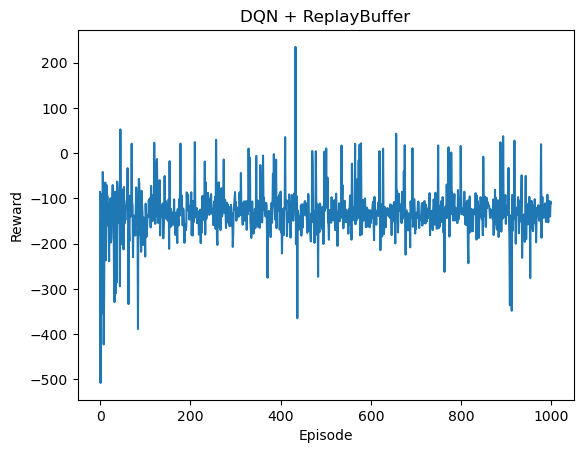

In [172]:
#window_size = 100
#moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
plt.plot(scores)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

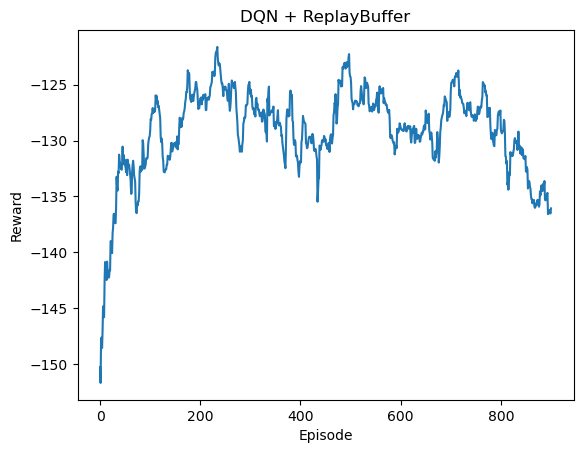

In [173]:
window_size = 100
moving_avg = np.convolve(scores, np.ones(window_size)/window_size, mode='valid')
plt.plot(moving_avg)
plt.title('DQN + ReplayBuffer')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()